# 1. Importación de librerías y carga de datos

In [ ]:
SCALED=True
STANDARIZED=False

In [ ]:
!pip install attention
!pip install codecarbon
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 66 kB 4.7 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from attention import Attention

if SCALED:
  from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
  from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
DATASETS_FOLDER = os.path.join("TFM", "implementation", "datasets")
POSITIONS_FILE = os.path.join(DATASETS_FOLDER, "positions.csv")
df = pd.read_csv(POSITIONS_FILE)

columns = ['time(s)', 'vehicle_id']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])
df.head()

In [ ]:
# Load MinMaxScaler for target variables
if SCALED:
  MINMAXSCALER_FILE = os.path.join("TFM", "implementation",
                             "data_preparation", "minmaxscaler.pkl")
  with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
    minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
  TARGETS_STAND_FILE = os.path.join("TFM", "implementation",
                                     "data_preparation", "targets_stand.pkl")
  with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
    standscaler_targets = pickle.load(f_scaler)

In [ ]:
# Load training dataset
if SCALED:
  DATASET_TRAIN = os.path.join(DATASETS_FOLDER,
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
  DATASET_TRAIN = os.path.join(DATASETS_FOLDER,
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
  DATASET_TRAIN = os.path.join(DATASETS_FOLDER,
                               "ventanas_no_coincidentes_train_val.npz")
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
  DATASET_TEST = os.path.join(DATASETS_FOLDER,
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
  DATASET_TEST = os.path.join(DATASETS_FOLDER,
                              "ventanas_no_coincidentes_test_stand.npz")
else:
  DATASET_TEST = os.path.join(DATASETS_FOLDER,
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join(DATASETS_FOLDER, "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
  vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (216426, 20, 3)  y_train: (216426, 5, 3)
X_val: (92755, 20, 3)  y_val: (92755, 5, 3)
X_test: (2584, 20, 3)  y_test: (2584, 5, 3)
Vehicle_ids: 2584


In [ ]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join(DATASETS_FOLDER, "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,2,5.0,1.8
1,3,5.0,1.8
2,4,2.2,0.9
3,5,5.0,1.8
4,6,5.0,1.8


In [ ]:
# Load dataset with vehicles colision
DATASET_COL = os.path.join(DATASETS_FOLDER, "collisions_1k.csv")
df_col = pd.read_csv(DATASET_COL)
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,2899,2884
1,8351,8507
2,6705,6636
3,7523,7414
4,651,541


In [ ]:
# Load dataset with vehicles no-colision
DATASET_NOCOL = os.path.join(DATASETS_FOLDER, "no_collisions_1k.csv")
df_nocol = pd.read_csv(DATASET_NOCOL)
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,6.0,85.0
1,29.0,61.0
2,38.0,266.0
3,38.0,300.0
4,38.0,315.0


# 2. Generación y entrenamiento de los modelos

In [ ]:
if SCALED:
  MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
elif STANDARIZED:
  MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
else:
  MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")

In [ ]:
# Windows parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading']

# Training parameters
EPOCHS=100
BATCH_SIZE=64
PATIENCE=5
REDUCELR=0.2

def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
  tracker = EmissionsTracker(log_level="error")
  callback_list = []

  # Return best model that minimize loss function
  early_stopping = EarlyStopping(
      monitor='val_loss', patience=patience*2, mode='min',
      restore_best_weights=True)
  callback_list.append(early_stopping)

  # Save best model that minimize loss function
  checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_file, monitor='val_loss', mode="min",
      save_best_only=True, verbose=0)
  callback_list.append(checkpoint)
  
  if reduce_lr != 0:
    # Reduce learning rate to minimize loss function
    reduce_learningrate = ReduceLROnPlateau(
        monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
    callback_list.append(reduce_learningrate)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=Adam(learning_rate=learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  tracker.start()
  start_time = time.time()
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)
  total_time = time.time() - start_time
  emissions = tracker.stop()

  # Save fit history
  history_pickle = os.path.join(folder, 'history.pkl')
  pickle.dump(history.history, open(history_pickle, 'wb'))

  # Print and write fit statistics
  min_val_loss = min(history.history['val_loss'])
  best_model_index = history.history['val_loss'].index(min_val_loss)
  print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
  print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
  print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
  print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
  print("Execution time (s): {}".format(total_time))
  print("Emissions (kg): {}\n".format(emissions))
  stats_file = os.path.join(folder, "stats.txt")
  with open(stats_file, 'w') as f_stats:
    f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
    f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
    f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
    f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
    f_stats.write("Execution time (s): {}\n".format(total_time))
    f_stats.write("Emissions (kg): {}\n".format(emissions))

  return history


def plot_history(history, start=None, end=None):
  train_loss = history['loss'][start:end]
  val_loss = history['val_loss'][start:end]
  train_mae = history['mean_absolute_error'][start:end]
  test_mae = history['val_mean_absolute_error'][start:end]

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ax[0].plot(train_loss, label="Train")
  ax[0].plot(val_loss, label="Validation")
  ax[0].set_title("Training and Validation loss")
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Loss")
  ax[0].legend()

  ax[1].plot(train_mae, label="Train")
  ax[1].plot(test_mae, label="Validation")
  ax[1].set_title("Training and Validation MAE")
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Mean Absolute Error")
  ax[1].legend()

  plt.show()


def model_predictions(model, X_test, y_test):
  def calculate_haversine(coord1, coord2):
    return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

  y_pred = model.predict(X_test)
  if SCALED:
    y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 3))
  elif STANDARIZED:
    y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
  y_pred = y_pred.reshape(-1, 3)

  if SCALED:
    y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 3))
  elif STANDARIZED:
    y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
  y_test = y_test.reshape(-1, 3)

  df_y_pred = pd.DataFrame(
      y_pred, columns=['latitude(pred)', 'longitude(pred)', 'heading(pred)'])
  df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading'])
  df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

  distance = df_pred.apply(
      lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                      (row['latitude'], row['longitude'])), axis=1)
  df_pred['distance(m)'] = distance

  return df_pred

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
  rlat1 = math.radians(a_lat)
  rlon1 = math.radians(a_lon)
  rlat2 = math.radians(b_lat)
  rlon2 = math.radians(b_lon)
  dlon = math.radians(b_lon - a_lon)
  b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
  bd = math.degrees(b)
  br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
  return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
  start = geopy.Point(coordinates)
  width = width/1000
  length = length/1000
  rectlength = geopy.distance.distance(kilometers=length)
  rectwidth = geopy.distance.distance(kilometers=width)
  halfwidth = geopy.distance.distance(kilometers=width/2)
  halflength = geopy.distance.distance(kilometers=length/2)

  pointAB = halflength.destination(point=start, bearing=bearing)
  pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
  pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
  pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
  pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

  points = []
  for point in [pointA, pointB, pointC, pointD]:
    coords = (point.latitude, point.longitude)
    points.append(coords)

  return points


def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
  colision = 0

  y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 3), verbose=0)
  if SCALED:
    y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 3))
  elif STANDARIZED:
    y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
  y_pred_v1 = y_pred_v1.reshape(-1, 3)
  v1_coord_5 = y_pred_v1[-1]
  # v1_coord_4 = y_pred_v1[-2]

  v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
  v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

  # v1_bearing = bearing_calc(v1_coord_4[0], v1_coord_4[1],
  #                           v1_coord_5[0], v1_coord_5[1])
  v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
  polygon1 = geometry.Polygon(v1_points)

  y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 3), verbose=0)
  if SCALED:
    y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 3))
  elif STANDARIZED:
    y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
  y_pred_v2 = y_pred_v2.reshape(-1, 3)
  v2_coord_5 = y_pred_v2[-1]
  # v2_coord_4 = y_pred_v2[-2]

  v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
  v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

  # v2_bearing = bearing_calc(v2_coord_4[0], v2_coord_4[1],
  #                           v2_coord_5[0], v2_coord_5[1])
  v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
  polygon2 = geometry.Polygon(v2_points)

  if polygon1.intersection(polygon2).area > 0.0:
    colision = 1
  
  return colision


def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
  total_colision = 0
  total_no_colision = 0

  true_positive = 0
  false_negative = 0
  false_positive = 0
  true_negative = 0

  # Vehiculos que coinciden y colisionan
  for i in range(df_col.shape[0]):
    v1_id = df_col.iloc[i, 0]
    v2_id = df_col.iloc[i, 1]

    v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
    v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
    intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
    if len(intersection) >= 2:
      total_colision += 1
      v1_index = vehicle_ids.index(v1_id)
      v2_index = vehicle_ids.index(v2_id)
      if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim,
                      model):
        true_positive += 1
      else:
        false_negative += 1

  # Vehiculos que coinciden pero no colisionan
  for i in range(df_nocol.shape[0]):
    v1_id = df_nocol.iloc[i, 0]
    v2_id = df_nocol.iloc[i, 1]

    v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
    v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
    intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
    if len(intersection) >= 2:
      total_no_colision += 1
      v1_index = vehicle_ids.index(v1_id)
      v2_index = vehicle_ids.index(v2_id)
      if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim,
                      model):
        false_positive += 1
      else:
        true_negative += 1


  accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
  precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
  recall = true_positive/(true_positive+false_negative)
  F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
  specificity = true_negative/(true_negative+false_positive)

  with open(metrics_file, 'w') as f_metrics:
    f_metrics.write("Total colision: {}\n".format(total_colision))
    f_metrics.write("TP: {}\n".format(true_positive))
    f_metrics.write("FN: {}\n".format(false_negative))
    f_metrics.write("Total no colision: {}\n".format(total_no_colision))
    f_metrics.write("FP: {}\n".format(false_positive))
    f_metrics.write("TN: {}\n\n".format(true_negative))
    f_metrics.write("Accuracy: {}\n".format(accuracy))
    f_metrics.write("Precision: {}\n".format(precision))
    f_metrics.write("Recall: {}\n".format(recall))
    f_metrics.write("F1 Score: {}\n".format(F1_score))
    f_metrics.write("Specificity: {}\n".format(specificity))


  print("Total colision: {}".format(total_colision))
  print("TP: {}".format(true_positive))
  print("FN: {}".format(false_negative))
  print("Total no colision: {}".format(total_no_colision))
  print("FP: {}".format(false_positive))
  print("TN: {}".format(true_negative))
  print()
  print("Accuracy: {}".format(accuracy))
  print("Precision: {}".format(precision))
  print("Recall: {}".format(recall))
  print("F1 Score: {}".format(F1_score))
  print("Specificity: {}".format(specificity))

## 2.1. Modelos simples

In [ ]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
  lstm_model = Sequential()

  # Shape [batch, time, in_features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))
  
  # Shape => [batch, out_steps*out_features].
  lstm_model.add(Dense(out_steps*out_features))

  # Shape => [batch, out_steps, out_features].
  lstm_model.add(Reshape([out_steps, out_features]))

  lstm_model.summary()

  return lstm_model


def make_gru_model(units, in_steps, out_steps, in_features, out_features):
  gru_model = Sequential()

  # Shape [batch, time, in_features] => [batch, gru_units].
  gru_model.add(GRU(units, input_shape=(in_steps, in_features)))

  # Shape => [batch, out_steps*out_features].
  gru_model.add(Dense(out_steps*out_features))

  # Shape => [batch, out_steps, out_features].
  gru_model.add(Reshape([out_steps, out_features]))

  gru_model.summary()

  return gru_model

### 2.1.1. Modelo GRU (32 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "GRU_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=32

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                           len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                3552      
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
 reshape_1 (Reshape)         (None, 5, 3)              0         
                                                                 
Total params: 4,047
Trainable params: 4,047
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 97s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0295 - val_loss: 0.0022 - val_mean_absolute_error: 0.0157 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 91s 27ms/step - loss: 0.0021 - mean_absolute_error: 0.0155 - val_loss: 0.0021

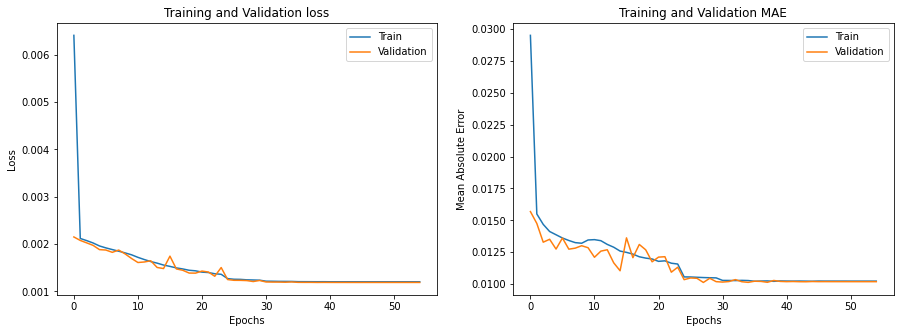

In [ ]:
plot_history(history.history)

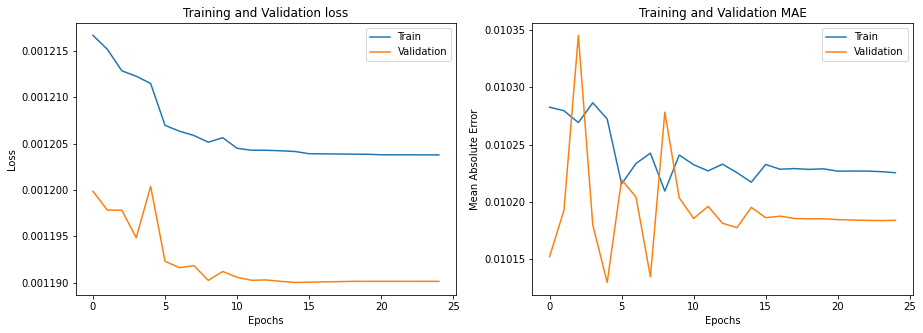

In [ ]:
plot_history(history.history, start=30)

#### 2.1.1.2. Predicción de la red

In [ ]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 1s 7ms/step
Distance(m): [0.05424415727852103, 70.54043708872925]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390242,2.164444,135.330389,41.390242,2.164442,128.847477,0.198099
1,41.390223,2.164458,132.607487,41.390252,2.164498,77.760806,4.637561
2,41.390218,2.164468,130.864596,41.390255,2.164505,72.874040,5.065662
3,41.390214,2.164486,123.632365,41.390256,2.164510,69.448483,5.130183
4,41.390203,2.164501,120.952572,41.390257,2.164510,69.122152,6.004666
...,...,...,...,...,...,...,...
12915,41.391242,2.165910,147.339446,41.391251,2.165894,152.734246,1.757409
12916,41.391190,2.165927,145.842863,41.391186,2.165929,157.962653,0.472226
12917,41.391154,2.165942,145.828424,41.391120,2.165965,158.301657,4.234874
12918,41.391122,2.165955,142.247831,41.391090,2.165987,156.359249,4.392522


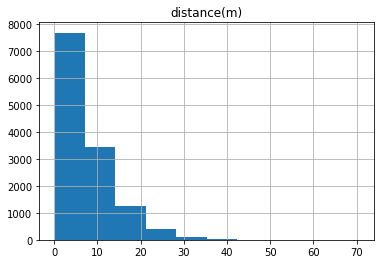

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.05424415727852103, 31.584545781676532]
Segundo 2: [0.13101239445584023, 29.573081186232745]
Segundo 3: [0.2549428010763061, 38.511253860975415]
Segundo 4: [0.07007396387981078, 54.83917160583352]
Segundo 5: [0.22886947987410405, 70.54043708872925]


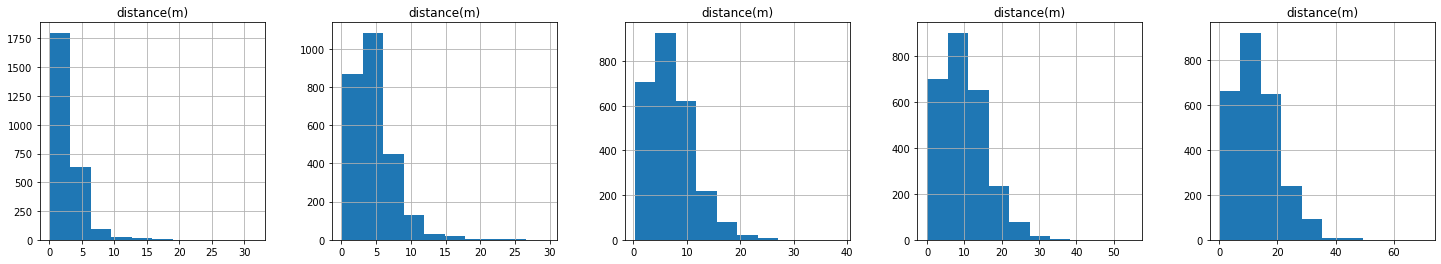

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390736,2.164779,165.121474,41.390738,2.164781,164.311173,2.917102
std,0.000773,0.001161,97.364749,0.000773,0.001168,99.848942,2.305617
min,41.387431,2.158517,23.820198,41.387357,2.158374,33.558601,0.054244
25%,41.390235,2.163940,65.271748,41.390241,2.163942,56.929802,1.585174
50%,41.390375,2.164481,138.371169,41.390385,2.164491,138.082230,2.499830
75%,41.391146,2.165599,228.359631,41.391154,2.165618,226.209520,3.488609
max,41.394008,2.167426,330.228790,41.393990,2.167493,325.723594,31.584546


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390739,2.164783,165.954868,41.390741,2.164790,163.786712,4.641012
std,0.000770,0.001173,95.353493,0.000770,0.001179,100.746739,2.938476
min,41.387353,2.158298,18.910009,41.387281,2.158277,23.673287,0.131012
25%,41.390236,2.163885,70.149597,41.390247,2.163844,58.907796,2.582294
50%,41.390363,2.164509,140.366692,41.390368,2.164511,138.127025,4.119731
75%,41.391150,2.165633,228.536822,41.391147,2.165674,226.209520,5.970115
max,41.393973,2.167483,329.942951,41.394006,2.167493,325.723594,29.573081


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390741,2.164788,166.981602,41.390746,2.164798,163.626592,7.113088
std,0.000768,0.001182,93.390498,0.000766,0.001191,101.859506,4.232466
min,41.387236,2.158116,15.744056,41.387195,2.158180,5.714497,0.254943
25%,41.390246,2.163837,74.114007,41.390257,2.163762,58.287742,3.854393
50%,41.390355,2.164541,142.887968,41.390352,2.164545,138.222234,6.602043
75%,41.391144,2.165662,228.979104,41.391152,2.165733,226.209520,9.384057
max,41.393983,2.167493,330.643870,41.394021,2.167493,329.427144,38.511254


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164791,167.731547,41.390751,2.164803,163.617546,9.928858
std,0.000765,0.001191,91.392625,0.000763,0.001203,102.413872,5.924599
min,41.387148,2.157928,16.238026,41.387111,2.158087,2.702005,0.070074
25%,41.390255,2.163807,81.341564,41.390277,2.163790,57.770335,5.168630
50%,41.390353,2.164565,144.589424,41.390339,2.164598,140.877186,9.211167
75%,41.391147,2.165680,229.601108,41.391141,2.165800,226.209520,13.254584
max,41.393983,2.167542,329.472699,41.394036,2.167506,343.864411,54.839172


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390746,2.164792,168.721107,41.390755,2.164803,169.082277,12.939129
std,0.000762,0.001201,89.461725,0.000757,0.001216,103.386991,7.672124
min,41.387048,2.157728,10.514407,41.387022,2.157973,0.437611,0.228869
25%,41.390270,2.163815,88.193259,41.390288,2.163845,68.784840,7.106357
50%,41.390356,2.164586,146.191568,41.390365,2.164600,163.397659,11.934769
75%,41.391146,2.165691,230.141867,41.391129,2.165866,232.136389,17.420834
max,41.394040,2.167657,330.059956,41.394120,2.167527,359.748667,70.540437


#### 2.1.1.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 29
FN: 971
Total no colision: 1000
FP: 25
TN: 975

Accuracy: 0.502
Precision: 0.5370370370370371
Recall: 0.029
F1 Score: 0.05502846299810247
Specificity: 0.975


### 2.1.2. Modelo GRU (64 unidades)

#### 2.1.2.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "GRU_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=64

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                           len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 14,223
Trainable params: 14,223
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 141s 41ms/step - loss: 0.0042 - mean_absolute_error: 0.0231 - val_loss: 0.0021 - val_mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 135s 40ms/step - loss: 0.0021 - mean_absolute_error: 0.0153 - val_loss: 0.00

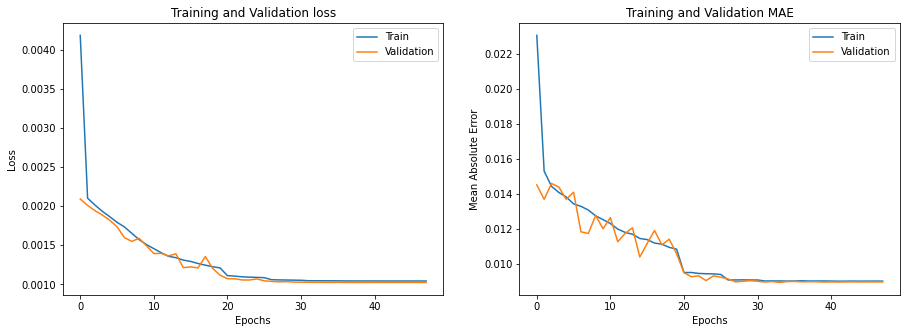

In [ ]:
plot_history(history.history)

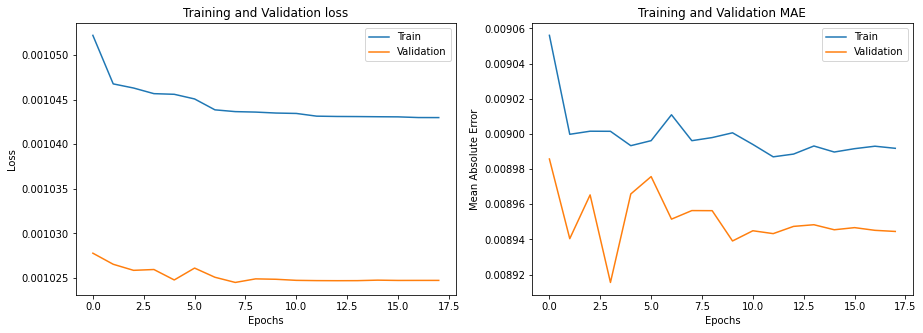

In [ ]:
plot_history(history.history, start=30)

#### 2.1.2.2. Predicción de la red

In [ ]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 1s 9ms/step
Distance(m): [0.025907412785562748, 52.15383897302661]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390247,2.164427,131.990557,41.390242,2.164442,128.847477,1.313097
1,41.390232,2.164451,129.183928,41.390252,2.164498,77.760806,4.479751
2,41.390212,2.164477,127.517203,41.390255,2.164505,72.874040,5.257238
3,41.390206,2.164509,122.997895,41.390256,2.164510,69.448483,5.629569
4,41.390206,2.164525,120.611233,41.390257,2.164510,69.122152,5.788119
...,...,...,...,...,...,...,...
12915,41.391253,2.165906,145.414177,41.391251,2.165894,152.734246,1.048353
12916,41.391208,2.165952,146.615335,41.391186,2.165929,157.962653,3.158786
12917,41.391178,2.166007,147.355600,41.391120,2.165965,158.301657,7.297110
12918,41.391154,2.166034,147.707298,41.391090,2.165987,156.359249,8.125874


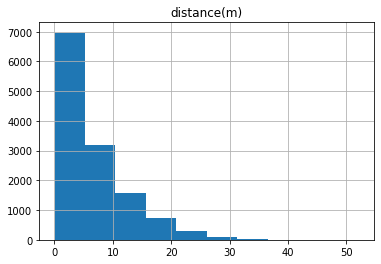

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.04673756545427882, 21.70359522315534]
Segundo 2: [0.025907412785562748, 32.438145661511086]
Segundo 3: [0.0729640896095422, 39.51265853627337]
Segundo 4: [0.18475200967345035, 51.46259028889448]
Segundo 5: [0.1895830077840332, 52.15383897302661]


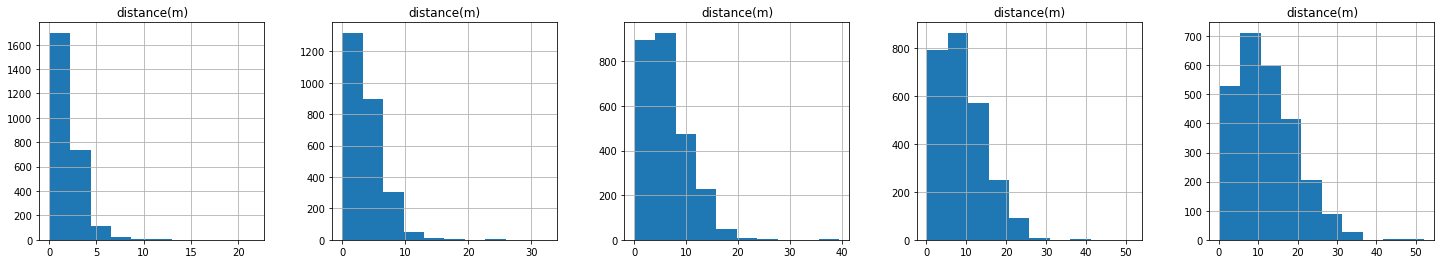

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390737,2.164778,163.650929,41.390738,2.164781,164.311173,2.050966
std,0.000776,0.001164,99.525434,0.000773,0.001168,99.848942,1.479696
min,41.387304,2.158318,8.886334,41.387357,2.158374,33.558601,0.046738
25%,41.390236,2.163942,62.555276,41.390241,2.163942,56.929802,1.088327
50%,41.390385,2.164483,139.243055,41.390385,2.164491,138.082230,1.715782
75%,41.391153,2.165611,228.524607,41.391154,2.165618,226.209520,2.627891
max,41.393969,2.167508,331.695875,41.393990,2.167493,325.723594,21.703595


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164785,164.225920,41.390741,2.164790,163.786712,3.784899
std,0.000774,0.001173,97.582147,0.000770,0.001179,100.746739,2.677483
min,41.387233,2.158263,4.696369,41.387281,2.158277,23.673287,0.025907
25%,41.390241,2.163871,66.860858,41.390247,2.163844,58.907796,1.789583
50%,41.390372,2.164520,141.701472,41.390368,2.164511,138.127025,3.215941
75%,41.391149,2.165663,227.583315,41.391147,2.165674,226.209520,5.153453
max,41.394061,2.167590,332.883448,41.394006,2.167493,325.723594,32.438146


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164790,165.475567,41.390746,2.164798,163.626592,6.273212
std,0.000771,0.001182,95.275004,0.000766,0.001191,101.859506,4.196990
min,41.387165,2.158191,-0.646269,41.387195,2.158180,5.714497,0.072964
25%,41.390244,2.163814,70.071866,41.390257,2.163762,58.287742,3.089711
50%,41.390359,2.164552,142.997768,41.390352,2.164545,138.222234,5.497687
75%,41.391144,2.165689,227.277262,41.391152,2.165733,226.209520,8.681907
max,41.394167,2.167564,326.388773,41.394021,2.167493,329.427144,39.512659


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164793,166.617992,41.390751,2.164803,163.617546,9.091006
std,0.000770,0.001192,92.844919,0.000763,0.001203,102.413872,5.808990
min,41.387078,2.158086,-6.752757,41.387111,2.158087,2.702005,0.184752
25%,41.390251,2.163780,76.022592,41.390277,2.163790,57.770335,4.597534
50%,41.390356,2.164580,145.489345,41.390339,2.164598,140.877186,8.227743
75%,41.391150,2.165713,227.019173,41.391141,2.165800,226.209520,12.534213
max,41.394324,2.167601,322.689249,41.394036,2.167506,343.864411,51.462590


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390749,2.164797,168.307864,41.390755,2.164803,169.082277,12.088408
std,0.000769,0.001202,90.056654,0.000757,0.001216,103.386991,7.446623
min,41.386987,2.157933,-3.888428,41.387022,2.157973,0.437611,0.189583
25%,41.390265,2.163779,88.427101,41.390288,2.163845,68.784840,6.102787
50%,41.390360,2.164608,147.227343,41.390365,2.164600,163.397659,10.924577
75%,41.391151,2.165732,226.666948,41.391129,2.165866,232.136389,16.889390
max,41.394504,2.167733,326.705965,41.394120,2.167527,359.748667,52.153839


#### 2.1.2.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 34
FN: 966
Total no colision: 1000
FP: 34
TN: 966

Accuracy: 0.5
Precision: 0.5
Recall: 0.034
F1 Score: 0.06367041198501873
Specificity: 0.966


### 2.1.3. Modelo GRU (128 unidades)

#### 2.1.3.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "GRU_128units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=128

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                           len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 53,007
Trainable params: 53,007
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 379s 111ms/step - loss: 0.0034 - mean_absolute_error: 0.0210 - val_loss: 0.0021 - val_mean_absolute_error: 0.0166 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 248s 73ms/step - loss: 0.0021 - mean_absolute_error: 0.0156 - val_loss: 0.0

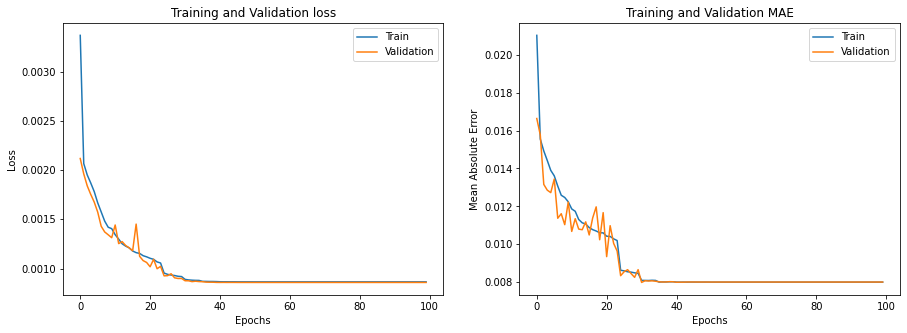

In [ ]:
plot_history(history.history)

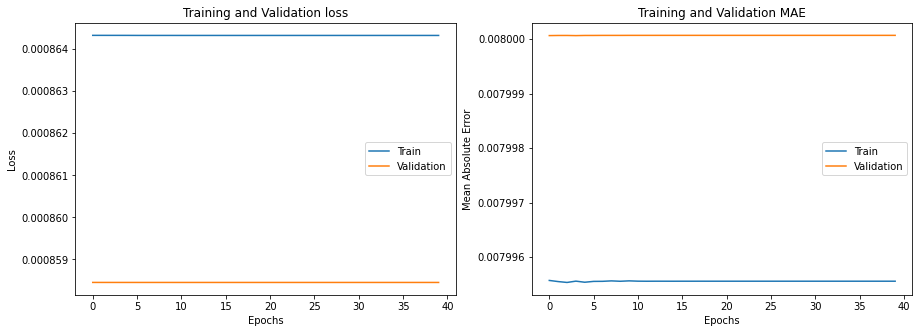

In [ ]:
plot_history(history.history, start=60)

#### 2.1.3.2. Predicción de la red

In [ ]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 19ms/step
Distance(m): [0.036035740050923186, 41.949661967518196]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390262,2.164445,131.231744,41.390242,2.164442,128.847477,2.179611
1,41.390255,2.164469,123.948626,41.390252,2.164498,77.760806,2.404659
2,41.390240,2.164493,114.297943,41.390255,2.164505,72.874040,1.875166
3,41.390242,2.164526,104.246347,41.390256,2.164510,69.448483,2.108457
4,41.390242,2.164561,97.769774,41.390257,2.164510,69.122152,4.499189
...,...,...,...,...,...,...,...
12915,41.391267,2.165880,145.005175,41.391251,2.165894,152.734246,2.105494
12916,41.391226,2.165919,143.193984,41.391186,2.165929,157.962653,4.568740
12917,41.391192,2.165951,140.056024,41.391120,2.165965,158.301657,8.065994
12918,41.391166,2.165984,136.976804,41.391090,2.165987,156.359249,8.492843


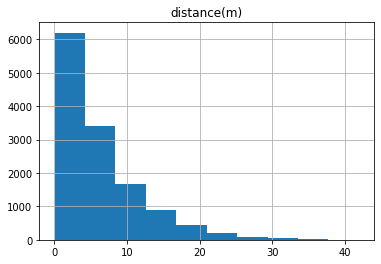

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.0376882186254958, 9.715809462793583]
Segundo 2: [0.036035740050923186, 16.765878289301522]
Segundo 3: [0.07444087697177236, 24.739143482473434]
Segundo 4: [0.2910545895218776, 33.17519335849598]
Segundo 5: [0.22877832006093107, 41.949661967518196]


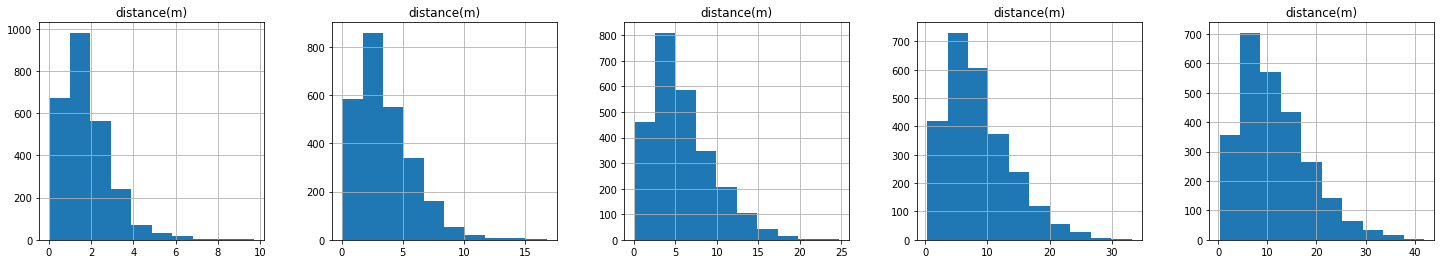

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390738,2.164777,163.438840,41.390738,2.164781,164.311173,1.796046
std,0.000774,0.001165,99.486553,0.000773,0.001168,99.848942,1.188334
min,41.387356,2.158390,0.258389,41.387357,2.158374,33.558601,0.037688
25%,41.390236,2.163952,59.527408,41.390241,2.163942,56.929802,0.980172
50%,41.390382,2.164474,139.514337,41.390385,2.164491,138.082230,1.561016
75%,41.391145,2.165607,228.051081,41.391154,2.165618,226.209520,2.345398
max,41.393988,2.167463,362.261006,41.393990,2.167493,325.723594,9.715809


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390742,2.164783,163.239230,41.390741,2.164790,163.786712,3.566344
std,0.000772,0.001173,97.622535,0.000770,0.001179,100.746739,2.329119
min,41.387284,2.158270,-10.501736,41.387281,2.158277,23.673287,0.036036
25%,41.390241,2.163879,64.940237,41.390247,2.163844,58.907796,1.813580
50%,41.390373,2.164513,141.886846,41.390368,2.164511,138.127025,3.075404
75%,41.391144,2.165652,227.269305,41.391147,2.165674,226.209520,4.867105
max,41.394001,2.167521,362.104557,41.394006,2.167493,325.723594,16.765878


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164788,163.974702,41.390746,2.164798,163.626592,5.902758
std,0.000769,0.001180,94.967844,0.000766,0.001191,101.859506,3.714494
min,41.387188,2.158172,-17.959857,41.387195,2.158180,5.714497,0.074441
25%,41.390248,2.163823,68.531502,41.390257,2.163762,58.287742,3.082823
50%,41.390364,2.164545,144.718330,41.390352,2.164545,138.222234,5.077483
75%,41.391140,2.165694,226.913989,41.391152,2.165733,226.209520,7.932013
max,41.394039,2.167628,353.141682,41.394021,2.167493,329.427144,24.739143


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390749,2.164792,165.172956,41.390751,2.164803,163.617546,8.566162
std,0.000766,0.001188,92.146812,0.000763,0.001203,102.413872,5.293578
min,41.387100,2.158064,-19.912768,41.387111,2.158087,2.702005,0.291055
25%,41.390259,2.163795,76.071641,41.390277,2.163790,57.770335,4.477696
50%,41.390366,2.164571,147.500024,41.390339,2.164598,140.877186,7.467972
75%,41.391147,2.165707,226.851190,41.391141,2.165800,226.209520,11.632047
max,41.394112,2.167726,340.775399,41.394036,2.167506,343.864411,33.175193


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390753,2.164794,167.095789,41.390755,2.164803,169.082277,11.456186
std,0.000765,0.001195,88.981440,0.000757,0.001216,103.386991,6.978891
min,41.387013,2.157945,-12.372713,41.387022,2.157973,0.437611,0.228778
25%,41.390273,2.163792,87.503530,41.390288,2.163845,68.784840,6.073663
50%,41.390366,2.164588,149.889487,41.390365,2.164600,163.397659,10.169848
75%,41.391141,2.165736,227.440581,41.391129,2.165866,232.136389,15.476603
max,41.394205,2.167767,332.058582,41.394120,2.167527,359.748667,41.949662


#### 2.1.3.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 51
FN: 949
Total no colision: 1000
FP: 26
TN: 974

Accuracy: 0.5125
Precision: 0.6623376623376623
Recall: 0.051
F1 Score: 0.09470752089136489
Specificity: 0.974


### 2.1.4. Modelo LSTM (32 unidades)

#### 2.1.4.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4608      
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
 reshape_1 (Reshape)         (None, 5, 3)              0         
                                                                 
Total params: 5,103
Trainable params: 5,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 81s 23ms/step - loss: 0.0052 - mean_absolute_error: 0.0292 - val_loss: 0.0022 - val_mean_absolute_error: 0.0174 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 77s 23ms/step - loss: 0.0021 - mean_absolute_error: 0.0166 - val_loss: 0.0022

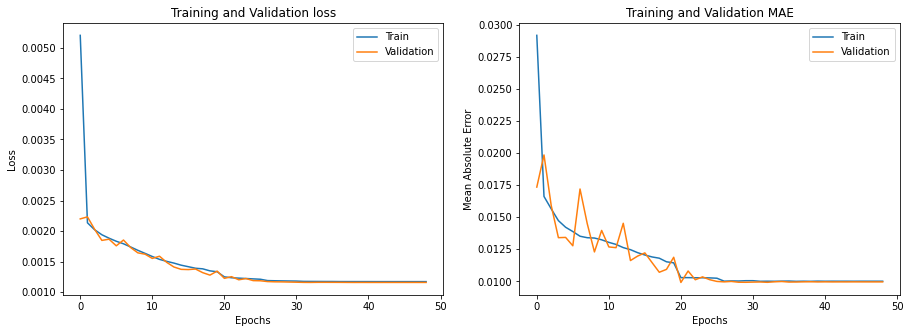

In [ ]:
plot_history(history.history)

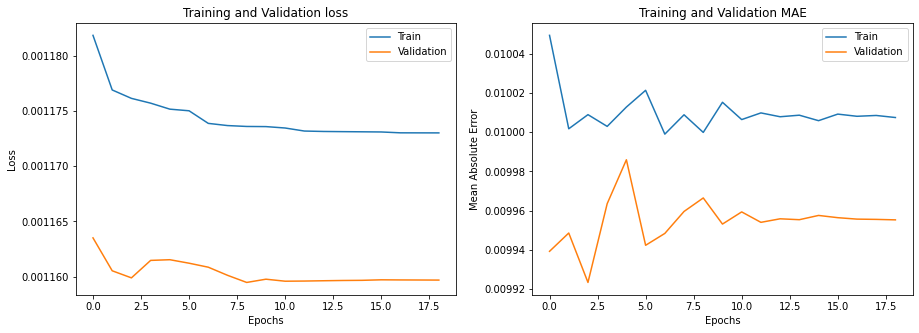

In [ ]:
plot_history(history.history, start=30)

#### 2.1.4.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 11ms/step
Distance(m): [0.09113599932311658, 59.10578092571252]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390256,2.164441,132.067711,41.390242,2.164442,128.847477,1.498176
1,41.390255,2.164474,128.886116,41.390252,2.164498,77.760806,2.018332
2,41.390258,2.164508,125.221310,41.390255,2.164505,72.874040,0.446224
3,41.390262,2.164542,121.423254,41.390256,2.164510,69.448483,2.725370
4,41.390269,2.164577,119.681049,41.390257,2.164510,69.122152,5.774409
...,...,...,...,...,...,...,...
12915,41.391248,2.165885,150.676692,41.391251,2.165894,152.734246,0.749253
12916,41.391207,2.165901,147.779635,41.391186,2.165929,157.962653,3.370760
12917,41.391164,2.165916,143.801864,41.391120,2.165965,158.301657,6.375145
12918,41.391137,2.165927,146.070607,41.391090,2.165987,156.359249,7.247610


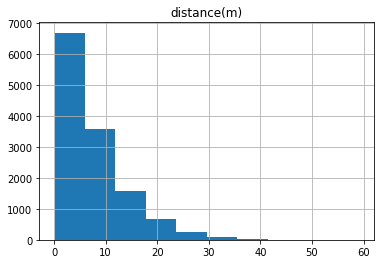

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.09113599932311658, 31.18743528322946]
Segundo 2: [0.12186951441151261, 28.19555788402559]
Segundo 3: [0.13851806314826687, 38.628651711525315]
Segundo 4: [0.10045683968575692, 49.17675507224792]
Segundo 5: [0.3416252731797644, 59.10578092571252]


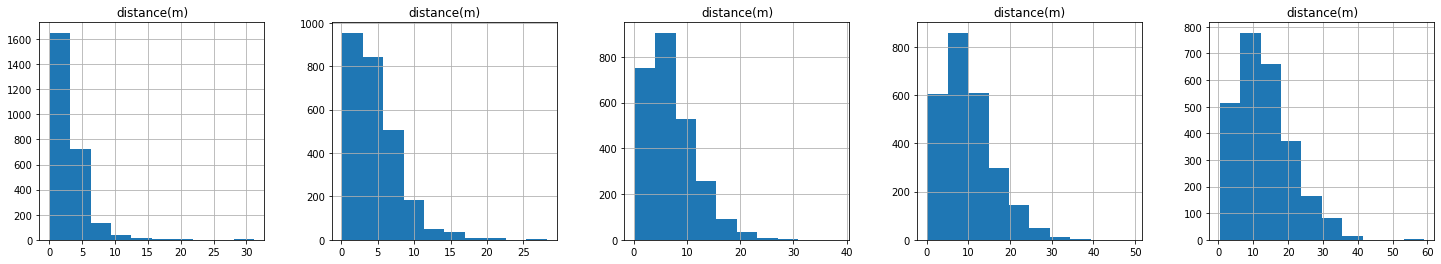

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390736,2.164777,165.189365,41.390738,2.164781,164.311173,3.133680
std,0.000775,0.001165,97.656740,0.000773,0.001168,99.848942,2.855183
min,41.387434,2.158594,22.866015,41.387357,2.158374,33.558601,0.091136
25%,41.390231,2.163971,64.982300,41.390241,2.163942,56.929802,1.391159
50%,41.390388,2.164466,138.501023,41.390385,2.164491,138.082230,2.409349
75%,41.391147,2.165587,228.987690,41.391154,2.165618,226.209520,4.118723
max,41.393960,2.167178,326.016419,41.393990,2.167493,325.723594,31.187435


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164782,166.037741,41.390741,2.164790,163.786712,4.619743
std,0.000772,0.001175,95.488716,0.000770,0.001179,100.746739,3.366261
min,41.387324,2.158368,17.823316,41.387281,2.158277,23.673287,0.121870
25%,41.390241,2.163903,68.932181,41.390247,2.163844,58.907796,2.150101
50%,41.390378,2.164501,140.314804,41.390368,2.164511,138.127025,3.919727
75%,41.391141,2.165624,228.921027,41.391147,2.165674,226.209520,6.261641
max,41.393987,2.167321,327.388944,41.394006,2.167493,325.723594,28.195558


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164787,167.026082,41.390746,2.164798,163.626592,7.041385
std,0.000769,0.001185,93.683580,0.000766,0.001191,101.859506,4.682020
min,41.387241,2.158177,17.459520,41.387195,2.158180,5.714497,0.138518
25%,41.390252,2.163841,74.609681,41.390257,2.163762,58.287742,3.527286
50%,41.390371,2.164532,143.162178,41.390352,2.164545,138.222234,6.152642
75%,41.391152,2.165661,228.915207,41.391152,2.165733,226.209520,9.539322
max,41.394039,2.167440,339.639882,41.394021,2.167493,329.427144,38.628652


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390746,2.164792,167.341267,41.390751,2.164803,163.617546,9.948783
std,0.000766,0.001193,91.934550,0.000763,0.001203,102.413872,6.212307
min,41.387098,2.158000,26.017017,41.387111,2.158087,2.702005,0.100457
25%,41.390264,2.163817,80.385255,41.390277,2.163790,57.770335,5.265840
50%,41.390364,2.164569,144.729663,41.390339,2.164598,140.877186,8.916020
75%,41.391155,2.165683,228.425300,41.391141,2.165800,226.209520,13.347406
max,41.394041,2.167564,336.730096,41.394036,2.167506,343.864411,49.176755


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390750,2.164796,168.474863,41.390755,2.164803,169.082277,13.180678
std,0.000763,0.001203,89.872916,0.000757,0.001216,103.386991,7.764785
min,41.386988,2.157795,26.935164,41.387022,2.157973,0.437611,0.341625
25%,41.390279,2.163796,87.855448,41.390288,2.163845,68.784840,7.110428
50%,41.390366,2.164592,146.816201,41.390365,2.164600,163.397659,12.107680
75%,41.391154,2.165703,227.119663,41.391129,2.165866,232.136389,17.810929
max,41.394126,2.167639,338.018752,41.394120,2.167527,359.748667,59.105781


#### 2.1.4.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 26
FN: 974
Total no colision: 1000
FP: 17
TN: 983

Accuracy: 0.5045
Precision: 0.6046511627906976
Recall: 0.026
F1 Score: 0.04985618408437199
Specificity: 0.983


### 2.1.5. Modelo LSTM (64 unidades)

#### 2.1.5.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 18,383
Trainable params: 18,383
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 183s 53ms/step - loss: 0.0045 - mean_absolute_error: 0.0273 - val_loss: 0.0023 - val_mean_absolute_error: 0.0175 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 174s 51ms/step - loss: 0.0021 - mean_absolute_error: 0.0163 - val_loss: 0.00

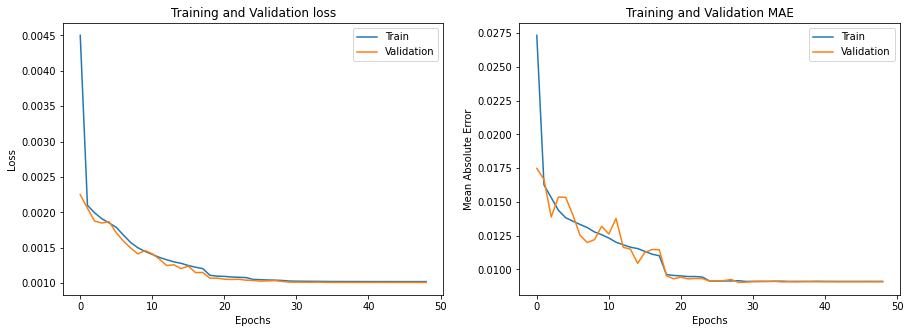

In [ ]:
plot_history(history.history)

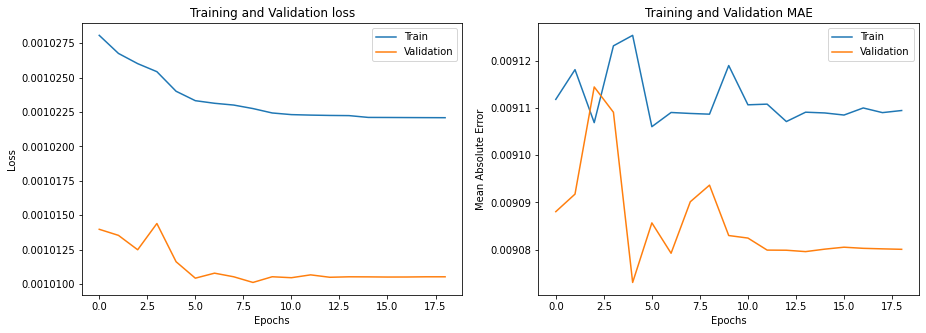

In [ ]:
plot_history(history.history, start=30)

#### 2.1.5.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 3s 17ms/step
Distance(m): [0.026172559144606727, 54.37993519552291]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390245,2.164405,131.916699,41.390242,2.164442,128.847477,3.059711
1,41.390233,2.164439,128.409933,41.390252,2.164498,77.760806,5.342025
2,41.390215,2.164457,123.334210,41.390255,2.164505,72.874040,5.985538
3,41.390214,2.164488,118.939874,41.390256,2.164510,69.448483,5.038537
4,41.390212,2.164507,114.911098,41.390257,2.164510,69.122152,4.931428
...,...,...,...,...,...,...,...
12915,41.391265,2.165890,147.178135,41.391251,2.165894,152.734246,1.551214
12916,41.391223,2.165927,146.388570,41.391186,2.165929,157.962653,4.115200
12917,41.391188,2.165974,143.863577,41.391120,2.165965,158.301657,7.553339
12918,41.391147,2.166010,140.713056,41.391090,2.165987,156.359249,6.626321


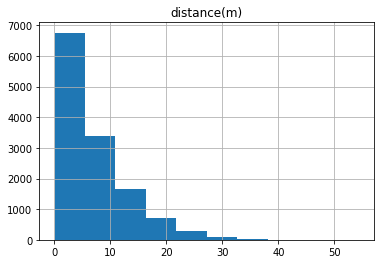

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.026172559144606727, 21.661206765586773]
Segundo 2: [0.09492080748672702, 20.00165712990545]
Segundo 3: [0.08563606243934396, 31.501030379564018]
Segundo 4: [0.21707862286971277, 42.29974982127341]
Segundo 5: [0.2526966450333603, 54.37993519552291]


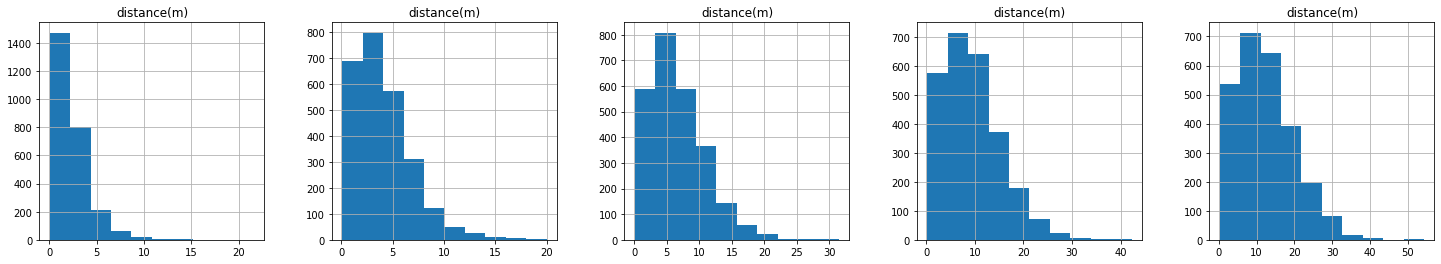

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390735,2.164777,163.502431,41.390738,2.164781,164.311173,2.387668
std,0.000774,0.001166,99.429546,0.000773,0.001168,99.848942,1.901451
min,41.387371,2.158397,-12.691507,41.387357,2.158374,33.558601,0.026173
25%,41.390233,2.163963,59.940092,41.390241,2.163942,56.929802,1.123965
50%,41.390385,2.164473,138.992889,41.390385,2.164491,138.082230,1.961044
75%,41.391149,2.165586,228.010097,41.391154,2.165618,226.209520,3.078574
max,41.393974,2.167325,327.828934,41.393990,2.167493,325.723594,21.661207


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390737,2.164782,164.174825,41.390741,2.164790,163.786712,4.108424
std,0.000772,0.001173,97.196827,0.000770,0.001179,100.746739,2.804085
min,41.387287,2.158281,-16.906262,41.387281,2.158277,23.673287,0.094921
25%,41.390238,2.163884,67.248298,41.390247,2.163844,58.907796,2.004779
50%,41.390369,2.164511,141.361654,41.390368,2.164511,138.127025,3.569023
75%,41.391138,2.165631,228.047676,41.391147,2.165674,226.209520,5.581854
max,41.394006,2.167438,328.976618,41.394006,2.167493,325.723594,20.001657


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164785,165.477016,41.390746,2.164798,163.626592,6.714000
std,0.000772,0.001181,94.614897,0.000766,0.001191,101.859506,4.220550
min,41.387162,2.158139,-15.280158,41.387195,2.158180,5.714497,0.085636
25%,41.390238,2.163831,70.181283,41.390257,2.163762,58.287742,3.468466
50%,41.390357,2.164546,143.693997,41.390352,2.164545,138.222234,5.980132
75%,41.391141,2.165666,227.039538,41.391152,2.165733,226.209520,9.135119
max,41.394111,2.167600,325.796624,41.394021,2.167493,329.427144,31.501030


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390744,2.164789,166.729724,41.390751,2.164803,163.617546,9.479921
std,0.000769,0.001186,92.301415,0.000763,0.001203,102.413872,5.831577
min,41.387055,2.158031,-14.189927,41.387111,2.158087,2.702005,0.217079
25%,41.390253,2.163790,78.424858,41.390277,2.163790,57.770335,4.795615
50%,41.390352,2.164575,145.816766,41.390339,2.164598,140.877186,8.655505
75%,41.391152,2.165695,227.897682,41.391141,2.165800,226.209520,12.988538
max,41.394227,2.167673,325.215388,41.394036,2.167506,343.864411,42.299750


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164790,168.365229,41.390755,2.164803,169.082277,12.462783
std,0.000765,0.001195,89.730307,0.000757,0.001216,103.386991,7.513415
min,41.386970,2.157929,-21.931928,41.387022,2.157973,0.437611,0.252697
25%,41.390265,2.163780,90.420908,41.390288,2.163845,68.784840,6.498713
50%,41.390355,2.164601,148.069934,41.390365,2.164600,163.397659,11.497415
75%,41.391152,2.165725,228.717303,41.391129,2.165866,232.136389,16.982653
max,41.394285,2.167815,326.153400,41.394120,2.167527,359.748667,54.379935


#### 2.1.5.3. Métricas del modelo

In [ ]:
# Load fitted model
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 47
FN: 953
Total no colision: 1000
FP: 33
TN: 967

Accuracy: 0.507
Precision: 0.5875
Recall: 0.047
F1 Score: 0.08703703703703704
Specificity: 0.967


### 2.1.6. Modelo LSTM (128 unidades)

#### 2.1.6.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "LSTM_128units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=128

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 69,519
Trainable params: 69,519
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 443s 130ms/step - loss: 0.0035 - mean_absolute_error: 0.0238 - val_loss: 0.0021 - val_mean_absolute_error: 0.0158 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 429s 127ms/step - loss: 0.0021 - mean_absolute_error: 0.0163 - val_loss: 0.

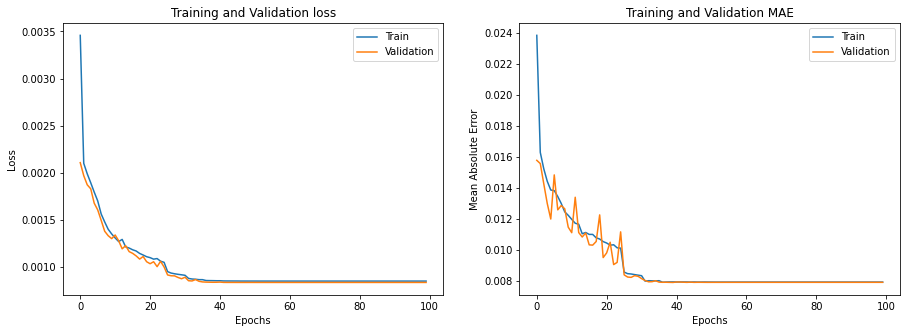

In [ ]:
plot_history(history.history)

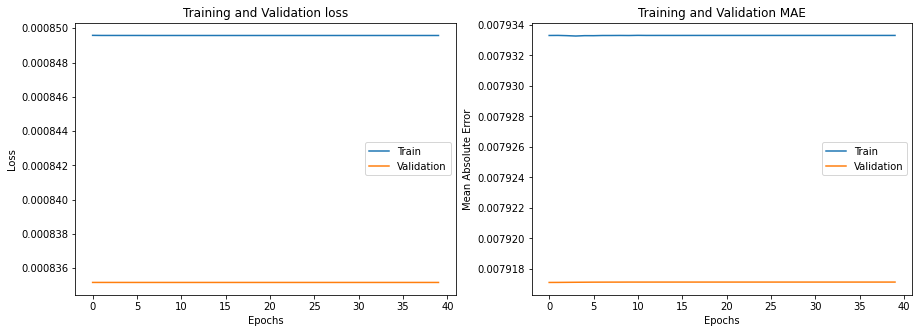

In [ ]:
plot_history(history.history, start=60)

#### 2.1.6.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 4s 31ms/step
Distance(m): [0.034735677480813125, 48.91534287038609]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390246,2.164423,135.074197,41.390242,2.164442,128.847477,1.648332
1,41.390248,2.164449,122.389983,41.390252,2.164498,77.760806,4.105375
2,41.390250,2.164488,108.038671,41.390255,2.164505,72.874040,1.494863
3,41.390280,2.164528,97.119414,41.390256,2.164510,69.448483,3.015544
4,41.390293,2.164565,89.946189,41.390257,2.164510,69.122152,6.088217
...,...,...,...,...,...,...,...
12915,41.391277,2.165905,146.798353,41.391251,2.165894,152.734246,3.055409
12916,41.391245,2.165954,145.151758,41.391186,2.165929,157.962653,6.913383
12917,41.391215,2.165996,143.043144,41.391120,2.165965,158.301657,10.830824
12918,41.391189,2.166038,140.991274,41.391090,2.165987,156.359249,11.804624


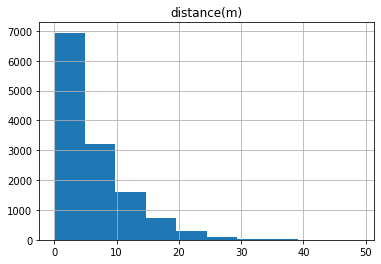

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.05314045659695069, 13.230161980329914]
Segundo 2: [0.034735677480813125, 19.561555863528085]
Segundo 3: [0.121688722022177, 28.38820401043215]
Segundo 4: [0.16587086309312268, 37.49594451543887]
Segundo 5: [0.2407360433904746, 48.91534287038609]


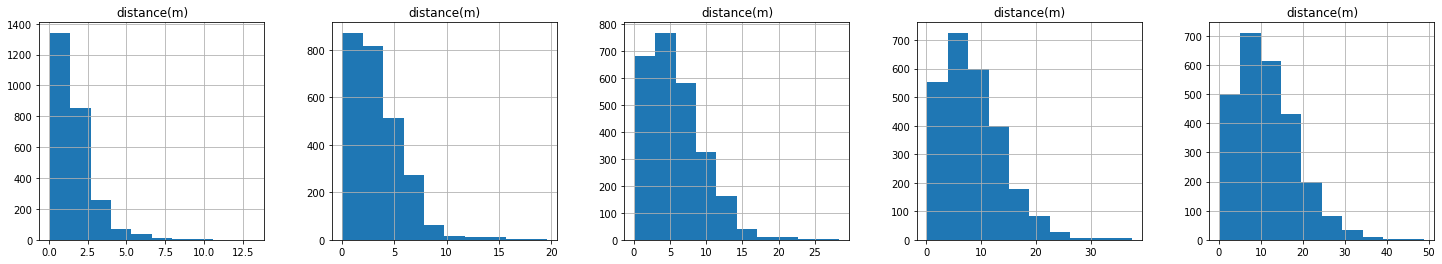

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390737,2.164779,163.446048,41.390738,2.164781,164.311173,1.639905
std,0.000773,0.001166,99.384125,0.000773,0.001168,99.848942,1.323685
min,41.387355,2.158378,2.660705,41.387357,2.158374,33.558601,0.053140
25%,41.390233,2.163949,57.325598,41.390241,2.163942,56.929802,0.766968
50%,41.390388,2.164478,138.885573,41.390385,2.164491,138.082230,1.324214
75%,41.391143,2.165619,227.797924,41.391154,2.165618,226.209520,2.081860
max,41.394000,2.167460,347.953159,41.393990,2.167493,325.723594,13.230162


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164784,163.473703,41.390741,2.164790,163.786712,3.425738
std,0.000771,0.001175,97.544537,0.000770,0.001179,100.746739,2.493813
min,41.387281,2.158263,9.218244,41.387281,2.158277,23.673287,0.034736
25%,41.390235,2.163879,63.288363,41.390247,2.163844,58.907796,1.524744
50%,41.390373,2.164511,140.968642,41.390368,2.164511,138.127025,2.910694
75%,41.391142,2.165659,227.277973,41.391147,2.165674,226.209520,4.827081
max,41.394006,2.167541,350.279909,41.394006,2.167493,325.723594,19.561556


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164788,164.596475,41.390746,2.164798,163.626592,5.821350
std,0.000769,0.001182,94.828089,0.000766,0.001191,101.859506,3.849267
min,41.387203,2.158157,-3.934189,41.387195,2.158180,5.714497,0.121689
25%,41.390242,2.163830,70.018504,41.390257,2.163762,58.287742,2.807157
50%,41.390361,2.164529,144.093399,41.390352,2.164545,138.222234,5.132823
75%,41.391144,2.165686,227.550468,41.391152,2.165733,226.209520,8.030573
max,41.394032,2.167575,345.971630,41.394021,2.167493,329.427144,28.388204


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390746,2.164791,166.023951,41.390751,2.164803,163.617546,8.580613
std,0.000767,0.001191,91.953904,0.000763,0.001203,102.413872,5.440358
min,41.387119,2.158057,-17.799686,41.387111,2.158087,2.702005,0.165871
25%,41.390254,2.163792,78.957701,41.390277,2.163790,57.770335,4.332769
50%,41.390360,2.164557,147.351214,41.390339,2.164598,140.877186,7.714369
75%,41.391152,2.165713,228.007401,41.391141,2.165800,226.209520,11.804538
max,41.394080,2.167646,333.850230,41.394036,2.167506,343.864411,37.495945


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390749,2.164792,168.070635,41.390755,2.164803,169.082277,11.627731
std,0.000765,0.001198,88.691070,0.000757,0.001216,103.386991,7.069089
min,41.387026,2.157908,-22.578613,41.387022,2.157973,0.437611,0.240736
25%,41.390269,2.163794,90.505262,41.390288,2.163845,68.784840,6.127302
50%,41.390364,2.164580,150.117038,41.390365,2.164600,163.397659,10.610216
75%,41.391146,2.165729,228.171797,41.391129,2.165866,232.136389,15.834885
max,41.394188,2.167725,336.835262,41.394120,2.167527,359.748667,48.915343


#### 2.1.6.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 45
FN: 955
Total no colision: 1000
FP: 25
TN: 975

Accuracy: 0.51
Precision: 0.6428571428571429
Recall: 0.045
F1 Score: 0.08411214953271028
Specificity: 0.975


## 2.2 Modelos profundos (stacked)

In [ ]:
def make_lstm_stacked_model(units1, units2, in_steps, out_steps, in_features,
                            out_features):
  lstm_model = Sequential()

  # Shape [batch, time, in_features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  lstm_model.add(LSTM(
      units1, input_shape=(in_steps, in_features), return_sequences=True))
  lstm_model.add(LSTM(units2))
  
  # Shape => [batch, out_steps*out_features].
  lstm_model.add(Dense(out_steps*out_features))

  # Shape => [batch, out_steps, out_features].
  lstm_model.add(Reshape([out_steps, out_features]))

  lstm_model.summary()

  return lstm_model


def make_gru_stacked_model(units1, units2, in_steps, out_steps, in_features,
                            out_features):
  gru_model = Sequential()

  # Shape [batch, time, in_features] => [batch, gru_units].
  # Adding more `gru_units` just overfits more quickly.
  gru_model.add(GRU(
      units1, input_shape=(in_steps, in_features), return_sequences=True))
  gru_model.add(GRU(units2))
  
  # Shape => [batch, out_steps*out_features].
  gru_model.add(Dense(out_steps*out_features))

  # Shape => [batch, out_steps, out_features].
  gru_model.add(Reshape([out_steps, out_features]))

  gru_model.summary()

  return gru_model

### 2.2.1. GRU stacked (32 - 32)

#### 2.2.1.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "stacked", "GRU_32_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS1=32
GRU_UNITS2=32

lstm_model = make_gru_stacked_model(
    GRU_UNITS1, GRU_UNITS2, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 32)            3552      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 10,383
Trainable params: 10,383
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 127s 36ms/step - loss: 0.0046 - mean_absolute_error: 0.0246 - val_loss: 0.0021 - val_mean_absolute_error: 0.0175 - lr: 0.0010
E

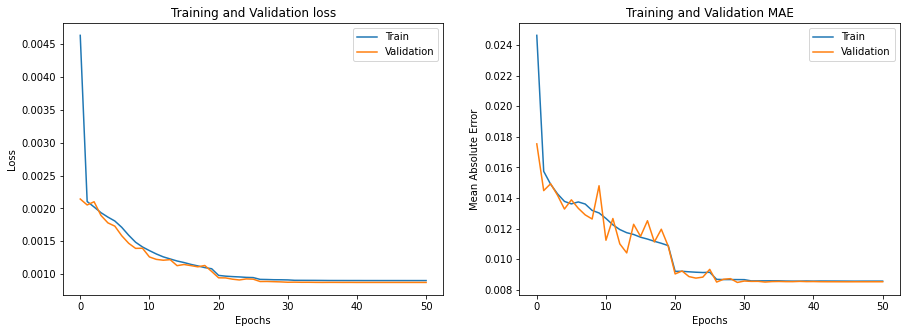

In [ ]:
plot_history(history.history)

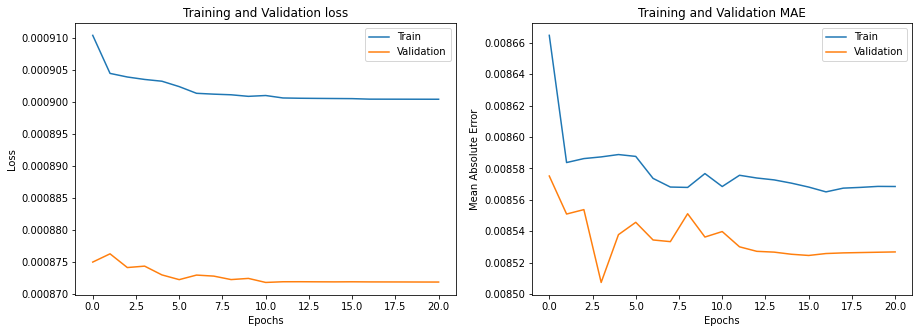

In [ ]:
plot_history(history.history, start=30)

#### 2.2.1.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 1s 8ms/step
Distance(m): [0.020050063684380327, 46.396940829444446]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390244,2.164452,134.923529,41.390242,2.164442,128.847477,0.899718
1,41.390230,2.164470,130.682053,41.390252,2.164498,77.760806,3.385751
2,41.390229,2.164479,125.503912,41.390255,2.164505,72.874040,3.561594
3,41.390224,2.164501,120.044795,41.390256,2.164510,69.448483,3.730632
4,41.390228,2.164517,116.636245,41.390257,2.164510,69.122152,3.238397
...,...,...,...,...,...,...,...
12915,41.391232,2.165906,154.054857,41.391251,2.165894,152.734246,2.342270
12916,41.391212,2.165917,153.403413,41.391186,2.165929,157.962653,3.169319
12917,41.391184,2.165927,150.360437,41.391120,2.165965,158.301657,7.771172
12918,41.391164,2.165932,147.921680,41.391090,2.165987,156.359249,9.398041


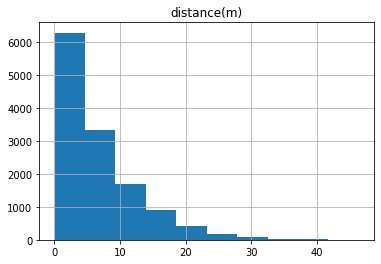

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.020050063684380327, 39.50344084505064]
Segundo 2: [0.039490490149373156, 32.34473572226933]
Segundo 3: [0.02006512710264334, 35.06249658804049]
Segundo 4: [0.06573097652115555, 39.53110045022323]
Segundo 5: [0.09551980466341937, 46.396940829444446]


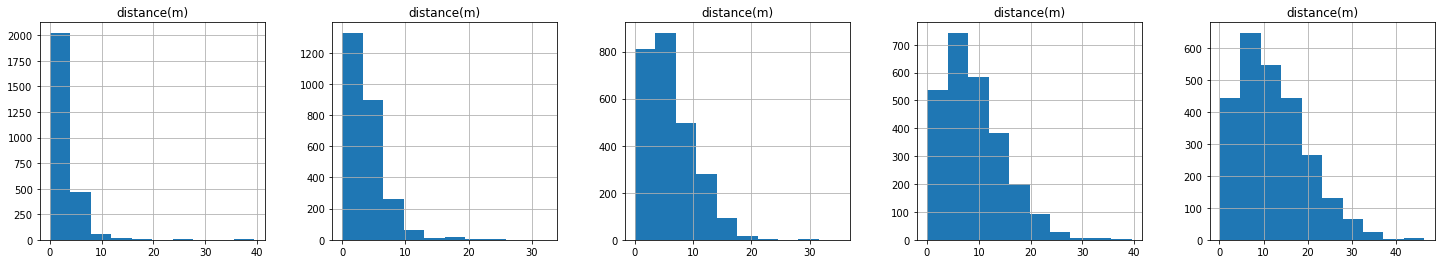

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390741,2.164782,162.823594,41.390738,2.164781,164.311173,2.929458
std,0.000769,0.001161,100.712604,0.000773,0.001168,99.848942,2.935320
min,41.387598,2.158709,-1.182590,41.387357,2.158374,33.558601,0.020050
25%,41.390233,2.163911,55.355864,41.390241,2.163942,56.929802,1.212751
50%,41.390389,2.164494,138.729756,41.390385,2.164491,138.082230,2.345808
75%,41.391170,2.165624,227.961280,41.391154,2.165618,226.209520,3.706576
max,41.393909,2.167413,351.679923,41.393990,2.167493,325.723594,39.503441


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164790,163.189080,41.390741,2.164790,163.786712,3.843889
std,0.000768,0.001172,98.518706,0.000770,0.001179,100.746739,2.994953
min,41.387360,2.158485,-59.620554,41.387281,2.158277,23.673287,0.039490
25%,41.390245,2.163866,64.682947,41.390247,2.163844,58.907796,1.844634
50%,41.390375,2.164527,139.983420,41.390368,2.164511,138.127025,3.185765
75%,41.391158,2.165665,227.320319,41.391147,2.165674,226.209520,5.146199
max,41.394003,2.167457,362.694405,41.394006,2.167493,325.723594,32.344736


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390749,2.164794,164.414260,41.390746,2.164798,163.626592,6.114941
std,0.000766,0.001182,95.850951,0.000766,0.001191,101.859506,4.109208
min,41.387196,2.158187,-50.818782,41.387195,2.158180,5.714497,0.020065
25%,41.390252,2.163828,69.611068,41.390257,2.163762,58.287742,2.940193
50%,41.390370,2.164562,143.185462,41.390352,2.164545,138.222234,5.278182
75%,41.391147,2.165691,227.527598,41.391152,2.165733,226.209520,8.588924
max,41.394064,2.167499,355.273320,41.394021,2.167493,329.427144,35.062497


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390752,2.164798,165.832903,41.390751,2.164803,163.617546,9.061267
std,0.000765,0.001195,93.028040,0.000763,0.001203,102.413872,5.823192
min,41.386965,2.158005,-78.200909,41.387111,2.158087,2.702005,0.065731
25%,41.390267,2.163796,75.519181,41.390277,2.163790,57.770335,4.542456
50%,41.390369,2.164581,145.393028,41.390339,2.164598,140.877186,8.074599
75%,41.391147,2.165715,227.162513,41.391141,2.165800,226.209520,12.487273
max,41.394147,2.167565,348.384964,41.394036,2.167506,343.864411,39.531100


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390757,2.164802,167.457914,41.390755,2.164803,169.082277,12.216485
std,0.000762,0.001202,90.184354,0.000757,0.001216,103.386991,7.604758
min,41.386839,2.157751,-77.597271,41.387022,2.157973,0.437611,0.095520
25%,41.390277,2.163793,86.928868,41.390288,2.163845,68.784840,6.053416
50%,41.390377,2.164610,147.532415,41.390365,2.164600,163.397659,10.969196
75%,41.391151,2.165722,226.899618,41.391129,2.165866,232.136389,16.932355
max,41.394212,2.167601,329.754782,41.394120,2.167527,359.748667,46.396941


#### 2.2.1.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 45
FN: 955
Total no colision: 1000
FP: 34
TN: 966

Accuracy: 0.5055
Precision: 0.569620253164557
Recall: 0.045
F1 Score: 0.08341056533827618
Specificity: 0.966


### 2.2.2. GRU stacked (64 - 32)

#### 2.2.2.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "stacked", "GRU_64_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS1=64
GRU_UNITS2=32

lstm_model = make_gru_stacked_model(
    GRU_UNITS1, GRU_UNITS2, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            13248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 23,151
Trainable params: 23,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 220s 64ms/step - loss: 0.0035 - mean_absolute_error: 0.0217 - val_loss: 0.0022 - val_mean_absolute_error: 0.0208 - lr: 0.0010
E

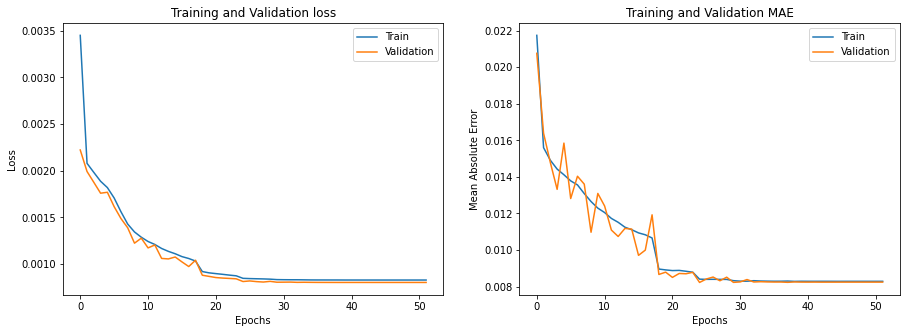

In [ ]:
plot_history(history.history)

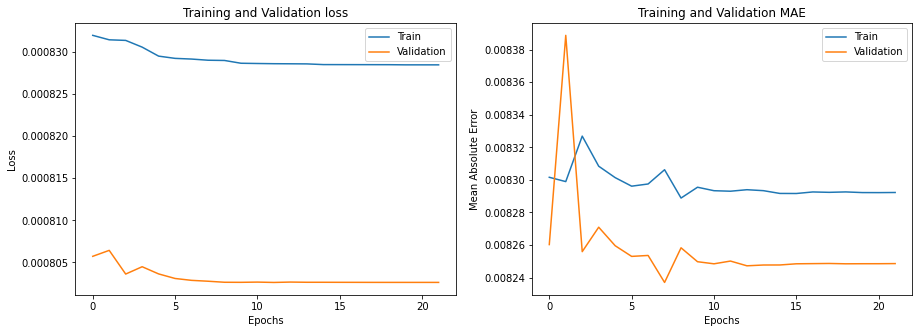

In [ ]:
plot_history(history.history, start=30)

#### 2.2.2.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 13ms/step
Distance(m): [0.026082422333160216, 42.00963642495302]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390219,2.164416,131.834990,41.390242,2.164442,128.847477,3.386780
1,41.390221,2.164454,124.086985,41.390252,2.164498,77.760806,4.997359
2,41.390221,2.164498,120.794472,41.390255,2.164505,72.874040,3.777029
3,41.390193,2.164472,114.648086,41.390256,2.164510,69.448483,7.744473
4,41.390221,2.164572,112.099152,41.390257,2.164510,69.122152,6.485709
...,...,...,...,...,...,...,...
12915,41.391236,2.165883,155.866397,41.391251,2.165894,152.734246,1.899210
12916,41.391205,2.165897,159.511757,41.391186,2.165929,157.962653,3.453429
12917,41.391182,2.165900,153.437587,41.391120,2.165965,158.301657,8.799017
12918,41.391133,2.165950,151.581966,41.391090,2.165987,156.359249,5.709236


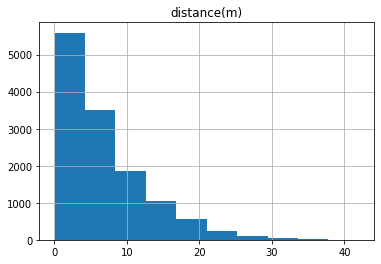

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.06186852945765066, 25.31708009632884]
Segundo 2: [0.026082422333160216, 22.676942224151077]
Segundo 3: [0.05768854095829792, 27.21565677021334]
Segundo 4: [0.10968583583624104, 33.235334446083726]
Segundo 5: [0.27168244095975724, 42.00963642495302]


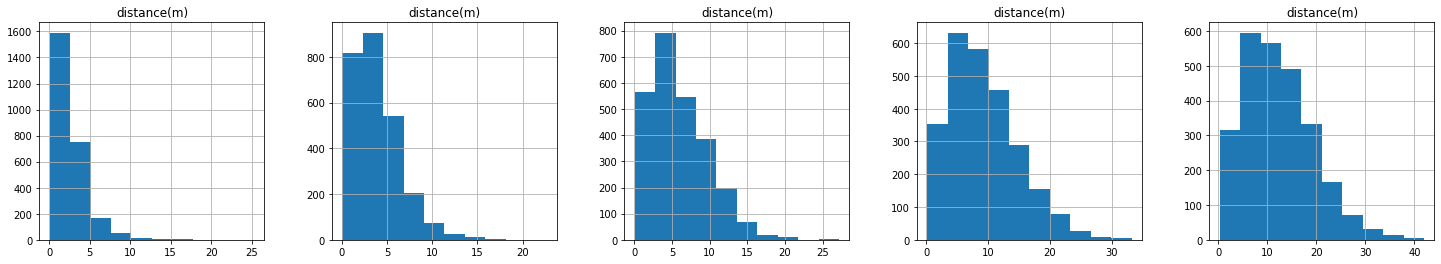

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164779,163.398096,41.390738,2.164781,164.311173,2.596550
std,0.000773,0.001166,99.313583,0.000773,0.001168,99.848942,2.094342
min,41.387243,2.158475,16.681071,41.387357,2.158374,33.558601,0.061869
25%,41.390232,2.163941,61.808804,41.390241,2.163942,56.929802,1.198474
50%,41.390384,2.164478,138.339765,41.390385,2.164491,138.082230,2.048372
75%,41.391158,2.165620,228.873069,41.391154,2.165618,226.209520,3.330287
max,41.393912,2.167429,351.111596,41.393990,2.167493,325.723594,25.317080


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164782,162.678387,41.390741,2.164790,163.786712,3.888673
std,0.000771,0.001172,98.150679,0.000770,0.001179,100.746739,2.663427
min,41.387240,2.158337,3.125458,41.387281,2.158277,23.673287,0.026082
25%,41.390235,2.163864,61.723295,41.390247,2.163844,58.907796,1.962095
50%,41.390376,2.164501,140.326136,41.390368,2.164511,138.127025,3.289259
75%,41.391151,2.165665,228.266066,41.391147,2.165674,226.209520,5.383348
max,41.393938,2.167327,367.128751,41.394006,2.167493,325.723594,22.676942


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164791,163.655166,41.390746,2.164798,163.626592,5.987390
std,0.000767,0.001182,95.538730,0.000766,0.001191,101.859506,3.882524
min,41.387174,2.158126,-56.516282,41.387195,2.158180,5.714497,0.057689
25%,41.390244,2.163806,66.861111,41.390257,2.163762,58.287742,3.032207
50%,41.390373,2.164540,143.454300,41.390352,2.164545,138.222234,5.158726
75%,41.391141,2.165702,228.423897,41.391152,2.165733,226.209520,8.393146
max,41.393991,2.167502,358.509040,41.394021,2.167493,329.427144,27.215657


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164789,164.642775,41.390751,2.164803,163.617546,9.268746
std,0.000765,0.001190,92.975905,0.000763,0.001203,102.413872,5.517644
min,41.387057,2.157953,-102.901316,41.387111,2.158087,2.702005,0.109686
25%,41.390258,2.163810,72.227095,41.390277,2.163790,57.770335,4.943258
50%,41.390372,2.164560,145.927388,41.390339,2.164598,140.877186,8.344009
75%,41.391147,2.165718,228.438895,41.391141,2.165800,226.209520,12.627353
max,41.394085,2.167565,341.629361,41.394036,2.167506,343.864411,33.235334


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164794,166.204813,41.390755,2.164803,169.082277,12.233715
std,0.000764,0.001198,90.113789,0.000757,0.001216,103.386991,6.943885
min,41.387023,2.157892,-101.613635,41.387022,2.157973,0.437611,0.271682
25%,41.390258,2.163794,81.919251,41.390288,2.163845,68.784840,6.788377
50%,41.390374,2.164592,148.263942,41.390365,2.164600,163.397659,11.199863
75%,41.391141,2.165737,226.702642,41.391129,2.165866,232.136389,16.663405
max,41.394171,2.167610,341.492293,41.394120,2.167527,359.748667,42.009636


#### 2.2.2.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 37
FN: 963
Total no colision: 1000
FP: 25
TN: 975

Accuracy: 0.506
Precision: 0.5967741935483871
Recall: 0.037
F1 Score: 0.06967984934086628
Specificity: 0.975


### 2.2.3. GRU stacked (64 - 64)

#### 2.2.3.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "stacked", "GRU_64_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS1=64
GRU_UNITS2=64

lstm_model = make_gru_stacked_model(
    GRU_UNITS1, GRU_UNITS2, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            13248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 39,183
Trainable params: 39,183
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 280s 81ms/step - loss: 0.0033 - mean_absolute_error: 0.0207 - val_loss: 0.0022 - val_mean_absolute_error: 0.0164 - lr: 0.0010
E

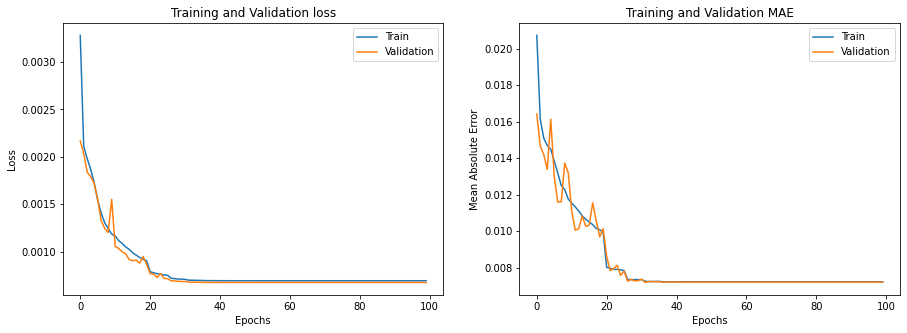

In [ ]:
plot_history(history.history)

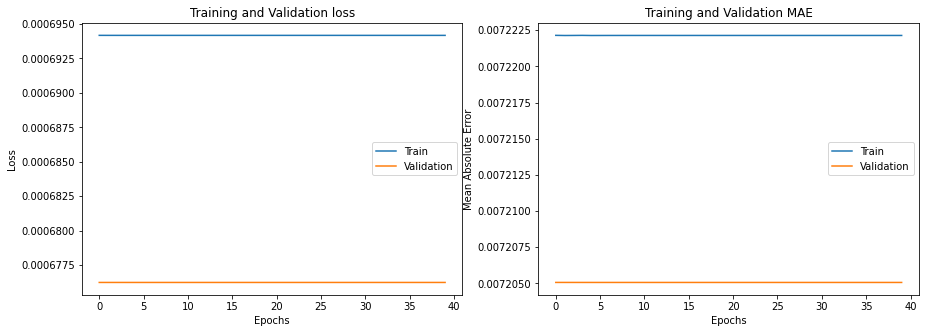

In [ ]:
plot_history(history.history, start=60)

#### 2.2.3.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 13ms/step
Distance(m): [0.023147373409165957, 40.32976707265345]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390229,2.164429,131.783997,41.390242,2.164442,128.847477,1.828288
1,41.390206,2.164458,129.049634,41.390252,2.164498,77.760806,6.105523
2,41.390192,2.164484,124.447065,41.390255,2.164505,72.874040,7.204209
3,41.390187,2.164513,117.763997,41.390256,2.164510,69.448483,7.713655
4,41.390181,2.164539,112.789706,41.390257,2.164510,69.122152,8.751115
...,...,...,...,...,...,...,...
12915,41.391258,2.165874,146.010643,41.391251,2.165894,152.734246,1.823644
12916,41.391215,2.165894,146.723699,41.391186,2.165929,157.962653,4.418279
12917,41.391167,2.165918,146.188117,41.391120,2.165965,158.301657,6.493257
12918,41.391127,2.165935,146.933177,41.391090,2.165987,156.359249,5.925469


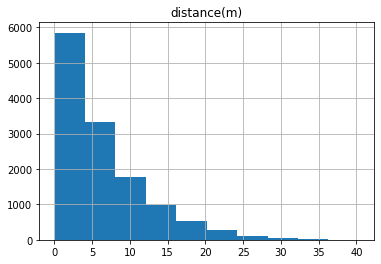

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.050176659362444795, 19.715393580715173]
Segundo 2: [0.023147373409165957, 20.078785773308272]
Segundo 3: [0.12178077937047059, 27.695250746982584]
Segundo 4: [0.14813057026691473, 33.92814619290004]
Segundo 5: [0.2150047999424926, 40.32976707265345]


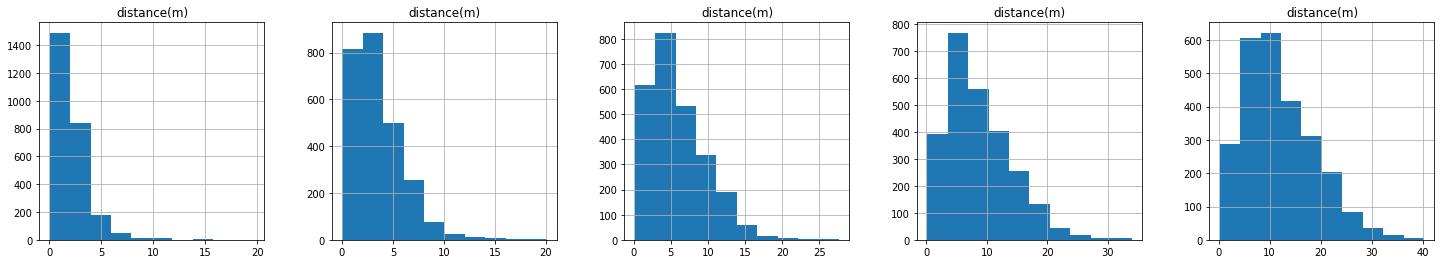

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390739,2.164778,163.660461,41.390738,2.164781,164.311173,2.157096
std,0.000773,0.001166,99.748079,0.000773,0.001168,99.848942,1.665651
min,41.387408,2.158467,-3.806954,41.387357,2.158374,33.558601,0.050177
25%,41.390234,2.163950,60.818556,41.390241,2.163942,56.929802,1.081397
50%,41.390387,2.164490,138.365799,41.390385,2.164491,138.082230,1.784748
75%,41.391149,2.165616,227.445391,41.391154,2.165618,226.209520,2.716081
max,41.394015,2.167471,341.626616,41.393990,2.167493,325.723594,19.715394


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390741,2.164783,163.049582,41.390741,2.164790,163.786712,3.552929
std,0.000771,0.001174,98.778102,0.000770,0.001179,100.746739,2.489533
min,41.387274,2.158273,-33.649126,41.387281,2.158277,23.673287,0.023147
25%,41.390238,2.163888,61.043612,41.390247,2.163844,58.907796,1.740392
50%,41.390372,2.164516,140.668585,41.390368,2.164511,138.127025,2.961830
75%,41.391139,2.165660,227.542590,41.391147,2.165674,226.209520,4.740448
max,41.394032,2.167522,335.935537,41.394006,2.167493,325.723594,20.078786


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164787,163.552586,41.390746,2.164798,163.626592,5.919663
std,0.000769,0.001182,95.819440,0.000766,0.001191,101.859506,3.839710
min,41.387188,2.158098,-28.550540,41.387195,2.158180,5.714497,0.121781
25%,41.390246,2.163838,64.967018,41.390257,2.163762,58.287742,2.958794
50%,41.390363,2.164547,142.750372,41.390352,2.164545,138.222234,5.047605
75%,41.391137,2.165695,226.819999,41.391152,2.165733,226.209520,8.220635
max,41.394028,2.167597,330.411924,41.394021,2.167493,329.427144,27.695251


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390746,2.164792,164.663242,41.390751,2.164803,163.617546,8.718957
std,0.000769,0.001189,92.768009,0.000763,0.001203,102.413872,5.332155
min,41.387085,2.157983,-41.150252,41.387111,2.158087,2.702005,0.148131
25%,41.390253,2.163801,74.816952,41.390277,2.163790,57.770335,4.643552
50%,41.390365,2.164578,145.703515,41.390339,2.164598,140.877186,7.596739
75%,41.391139,2.165714,226.822618,41.391141,2.165800,226.209520,11.965049
max,41.394100,2.167651,334.820370,41.394036,2.167506,343.864411,33.928146


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164794,166.796325,41.390755,2.164803,169.082277,11.898547
std,0.000767,0.001197,89.420090,0.000757,0.001216,103.386991,6.838421
min,41.386938,2.157805,-51.233718,41.387022,2.157973,0.437611,0.215005
25%,41.390263,2.163781,88.479729,41.390288,2.163845,68.784840,6.566321
50%,41.390373,2.164602,148.170656,41.390365,2.164600,163.397659,10.614383
75%,41.391133,2.165732,227.764486,41.391129,2.165866,232.136389,16.307980
max,41.394180,2.167723,372.109325,41.394120,2.167527,359.748667,40.329767


#### 2.2.3.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 29
FN: 971
Total no colision: 1000
FP: 28
TN: 972

Accuracy: 0.5005
Precision: 0.5087719298245614
Recall: 0.029
F1 Score: 0.05487228003784295
Specificity: 0.972


### 2.2.4. LSTM stacked (32 - 32)

#### 2.2.4.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "stacked", "LSTM_32_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS1=32
LSTM_UNITS2=32

lstm_model = make_lstm_stacked_model(
    LSTM_UNITS1, LSTM_UNITS2, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4608      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 13,423
Trainable params: 13,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 157s 45ms/step - loss: 0.0048 - mean_absolute_error: 0.0295 - val_loss: 0.0023 - val_mean_absolute_error: 0.0208 - lr: 0.0010
E

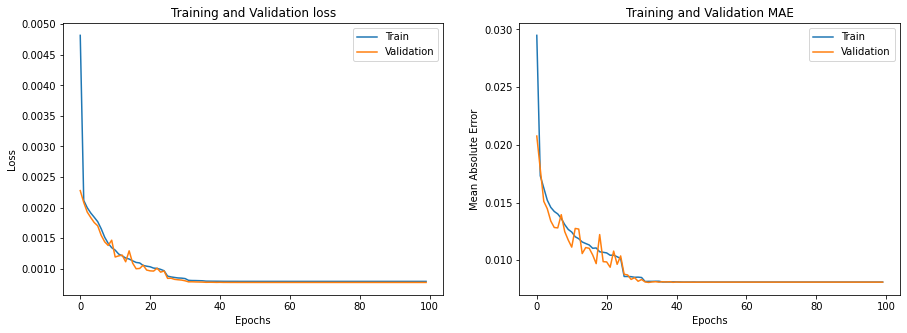

In [ ]:
plot_history(history.history)

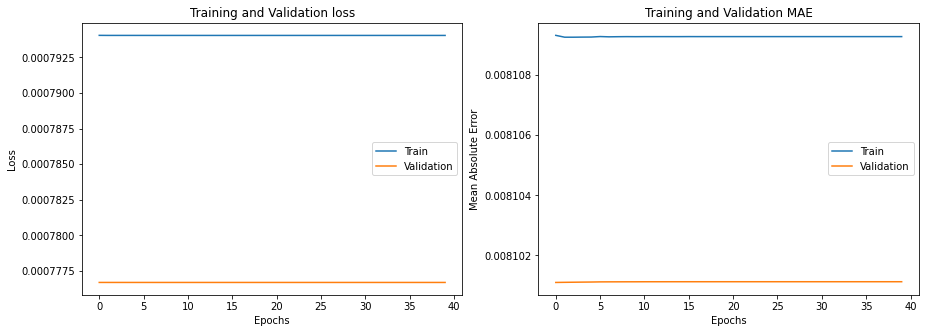

In [ ]:
plot_history(history.history, start=60)

#### 2.2.4.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 3s 11ms/step
Distance(m): [0.02935017639652119, 45.51366401377509]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390255,2.164448,124.696028,41.390242,2.164442,128.847477,1.555705
1,41.390241,2.164470,118.000325,41.390252,2.164498,77.760806,2.579006
2,41.390230,2.164492,109.697150,41.390255,2.164505,72.874040,2.917317
3,41.390224,2.164519,100.508108,41.390256,2.164510,69.448483,3.732316
4,41.390223,2.164546,93.276118,41.390257,2.164510,69.122152,4.791304
...,...,...,...,...,...,...,...
12915,41.391235,2.165853,154.096620,41.391251,2.165894,152.734246,3.849487
12916,41.391225,2.165853,154.249462,41.391186,2.165929,157.962653,7.700666
12917,41.391215,2.165853,150.632030,41.391120,2.165965,158.301657,14.061909
12918,41.391206,2.165855,147.325117,41.391090,2.165987,156.359249,16.948548


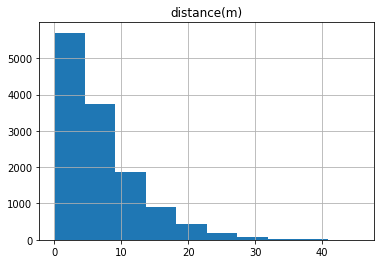

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.06013793946894746, 21.935611002979307]
Segundo 2: [0.02935017639652119, 20.372693852298795]
Segundo 3: [0.06533529305123136, 29.454552482585008]
Segundo 4: [0.12285370849794038, 39.4187770088766]
Segundo 5: [0.10075051823340946, 45.51366401377509]


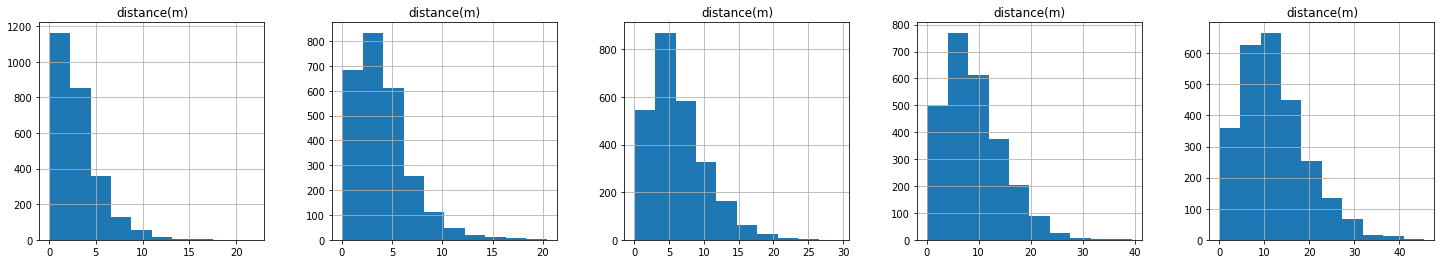

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390737,2.164776,163.712324,41.390738,2.164781,164.311173,3.138351
std,0.000774,0.001170,99.375759,0.000773,0.001168,99.848942,2.396245
min,41.387387,2.158412,-11.815277,41.387357,2.158374,33.558601,0.060138
25%,41.390226,2.163950,57.061927,41.390241,2.163942,56.929802,1.467707
50%,41.390381,2.164468,138.858726,41.390385,2.164491,138.082230,2.518362
75%,41.391150,2.165618,227.897654,41.391154,2.165618,226.209520,4.159296
max,41.393983,2.167603,339.210539,41.393990,2.167493,325.723594,21.935611


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164781,163.231712,41.390741,2.164790,163.786712,4.021535
std,0.000772,0.001178,97.972177,0.000770,0.001179,100.746739,2.764201
min,41.387294,2.158297,-18.839420,41.387281,2.158277,23.673287,0.029350
25%,41.390240,2.163891,65.248226,41.390247,2.163844,58.907796,1.987160
50%,41.390374,2.164504,141.321801,41.390368,2.164511,138.127025,3.497926
75%,41.391149,2.165664,227.071724,41.391147,2.165674,226.209520,5.342419
max,41.393996,2.167702,349.446542,41.394006,2.167493,325.723594,20.372694


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390744,2.164786,164.047241,41.390746,2.164798,163.626592,6.275562
std,0.000771,0.001185,95.445454,0.000766,0.001191,101.859506,3.997773
min,41.387191,2.158180,-38.174886,41.387195,2.158180,5.714497,0.065335
25%,41.390247,2.163822,68.978132,41.390257,2.163762,58.287742,3.341086
50%,41.390368,2.164540,144.331658,41.390352,2.164545,138.222234,5.494796
75%,41.391147,2.165702,227.261221,41.391152,2.165733,226.209520,8.448146
max,41.394015,2.167799,344.907507,41.394021,2.167493,329.427144,29.454552


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164790,165.598853,41.390751,2.164803,163.617546,9.134484
std,0.000769,0.001193,92.581785,0.000763,0.001203,102.413872,5.547491
min,41.387093,2.158072,-53.461065,41.387111,2.158087,2.702005,0.122854
25%,41.390256,2.163799,77.881527,41.390277,2.163790,57.770335,4.865039
50%,41.390366,2.164574,146.422734,41.390339,2.164598,140.877186,8.152989
75%,41.391149,2.165726,227.453849,41.391141,2.165800,226.209520,12.378365
max,41.394049,2.167886,328.749247,41.394036,2.167506,343.864411,39.418777


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390751,2.164792,167.901172,41.390755,2.164803,169.082277,12.224064
std,0.000766,0.001199,89.471443,0.000757,0.001216,103.386991,7.200065
min,41.387014,2.157961,-49.051177,41.387022,2.157973,0.437611,0.100751
25%,41.390269,2.163786,89.816345,41.390288,2.163845,68.784840,6.635202
50%,41.390370,2.164595,148.363066,41.390365,2.164600,163.397659,11.219536
75%,41.391146,2.165735,227.741100,41.391129,2.165866,232.136389,16.666192
max,41.394119,2.167973,362.378238,41.394120,2.167527,359.748667,45.513664


#### 2.2.4.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 29
FN: 971
Total no colision: 1000
FP: 30
TN: 970

Accuracy: 0.4995
Precision: 0.4915254237288136
Recall: 0.029
F1 Score: 0.05476864966949953
Specificity: 0.97


### 2.2.5. LSTM stacked (64 - 32)

#### 2.2.5.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "stacked", "LSTM_64_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS1=64
LSTM_UNITS2=32

lstm_model = make_lstm_stacked_model(
    LSTM_UNITS1, LSTM_UNITS2, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 30,319
Trainable params: 30,319
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 187s 54ms/step - loss: 0.0040 - mean_absolute_error: 0.0273 - val_loss: 0.0021 - val_mean_absolute_error: 0.0189 - lr: 0.0010
E

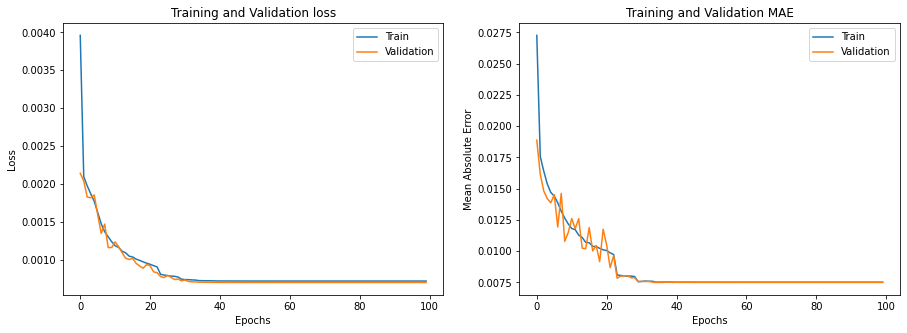

In [ ]:
plot_history(history.history)

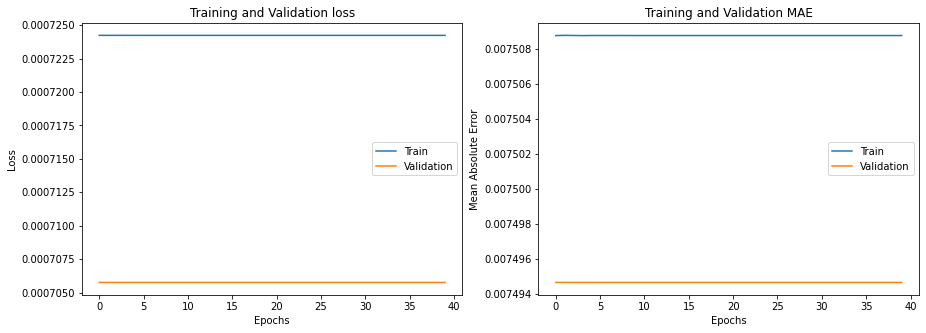

In [ ]:
plot_history(history.history, start=60)

#### 2.2.5.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 13ms/step
Distance(m): [0.040758417041488644, 51.73913170888598]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390238,2.164442,122.843944,41.390242,2.164442,128.847477,0.481421
1,41.390243,2.164470,112.111119,41.390252,2.164498,77.760806,2.536549
2,41.390238,2.164509,101.876394,41.390255,2.164505,72.874040,1.878016
3,41.390263,2.164545,90.133045,41.390256,2.164510,69.448483,3.025074
4,41.390267,2.164595,83.604090,41.390257,2.164510,69.122152,7.130230
...,...,...,...,...,...,...,...
12915,41.391236,2.165860,152.420033,41.391251,2.165894,152.734246,3.294952
12916,41.391199,2.165891,152.838387,41.391186,2.165929,157.962653,3.493003
12917,41.391169,2.165925,152.203775,41.391120,2.165965,158.301657,6.328477
12918,41.391138,2.165947,151.111091,41.391090,2.165987,156.359249,6.287675


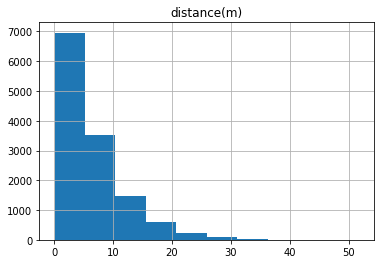

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.07112424054842938, 21.81772670633625]
Segundo 2: [0.11859289330252812, 20.52922858148526]
Segundo 3: [0.040758417041488644, 33.605247770622846]
Segundo 4: [0.21290766650806753, 36.91792056862034]
Segundo 5: [0.0767966958483972, 51.73913170888598]


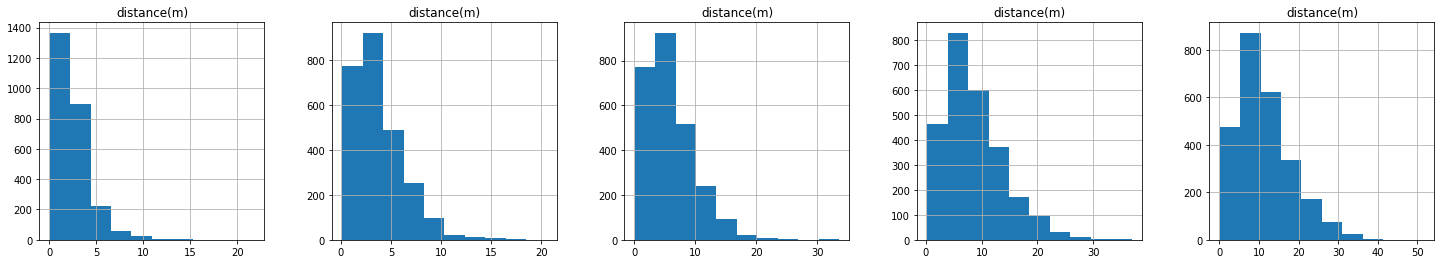

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164780,163.767127,41.390738,2.164781,164.311173,2.550590
std,0.000774,0.001167,98.509048,0.000773,0.001168,99.848942,1.854911
min,41.387392,2.158376,-5.856368,41.387357,2.158374,33.558601,0.071124
25%,41.390234,2.163930,59.820584,41.390241,2.163942,56.929802,1.305818
50%,41.390391,2.164489,139.428612,41.390385,2.164491,138.082230,2.134902
75%,41.391156,2.165616,227.937643,41.391154,2.165618,226.209520,3.252854
max,41.393959,2.167406,327.262793,41.393990,2.167493,325.723594,21.817727


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164783,162.666688,41.390741,2.164790,163.786712,3.762651
std,0.000771,0.001175,98.285689,0.000770,0.001179,100.746739,2.503952
min,41.387272,2.158267,8.103298,41.387281,2.158277,23.673287,0.118593
25%,41.390246,2.163874,63.452819,41.390247,2.163844,58.907796,1.906590
50%,41.390384,2.164520,141.661690,41.390368,2.164511,138.127025,3.227100
75%,41.391143,2.165648,228.086625,41.391147,2.165674,226.209520,5.086447
max,41.394012,2.167485,336.939166,41.394006,2.167493,325.723594,20.529229


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164791,163.290419,41.390746,2.164798,163.626592,5.974395
std,0.000770,0.001182,95.859481,0.000766,0.001191,101.859506,3.921048
min,41.387196,2.158197,-28.295019,41.387195,2.158180,5.714497,0.040758
25%,41.390250,2.163833,67.467488,41.390257,2.163762,58.287742,2.992449
50%,41.390375,2.164551,144.321575,41.390352,2.164545,138.222234,5.088566
75%,41.391146,2.165706,228.047273,41.391152,2.165733,226.209520,8.097304
max,41.394046,2.167562,324.902870,41.394021,2.167493,329.427144,33.605248


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390752,2.164791,164.527122,41.390751,2.164803,163.617546,8.592233
std,0.000766,0.001191,92.919627,0.000763,0.001203,102.413872,5.321969
min,41.387125,2.158010,-40.624778,41.387111,2.158087,2.702005,0.212908
25%,41.390270,2.163794,75.715236,41.390277,2.163790,57.770335,4.590206
50%,41.390369,2.164578,146.737604,41.390339,2.164598,140.877186,7.530399
75%,41.391149,2.165719,229.049327,41.391141,2.165800,226.209520,11.610049
max,41.394060,2.167619,376.100930,41.394036,2.167506,343.864411,36.917921


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390754,2.164798,167.017805,41.390755,2.164803,169.082277,11.413033
std,0.000766,0.001198,89.540298,0.000757,0.001216,103.386991,6.921127
min,41.387023,2.157923,-34.228543,41.387022,2.157973,0.437611,0.076797
25%,41.390278,2.163797,87.548615,41.390288,2.163845,68.784840,6.069412
50%,41.390371,2.164606,148.449171,41.390365,2.164600,163.397659,10.072762
75%,41.391148,2.165739,228.676059,41.391129,2.165866,232.136389,15.296195
max,41.394185,2.167687,428.162059,41.394120,2.167527,359.748667,51.739132


#### 2.2.5.3. Métricas del modelo

In [ ]:
# Load fitted model
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 25
FN: 975
Total no colision: 1000
FP: 20
TN: 980

Accuracy: 0.5025
Precision: 0.5555555555555556
Recall: 0.025
F1 Score: 0.04784688995215311
Specificity: 0.98


### 2.2.6. LSTM stacked (64 - 64)

#### 2.2.6.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "stacked", "LSTM_64_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS1=64
LSTM_UNITS2=64

lstm_model = make_lstm_stacked_model(
    LSTM_UNITS1, LSTM_UNITS2, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 51,407
Trainable params: 51,407
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 571s 167ms/step - loss: 0.0037 - mean_absolute_error: 0.0262 - val_loss: 0.0022 - val_mean_absolute_error: 0.0190 - lr: 0.0010


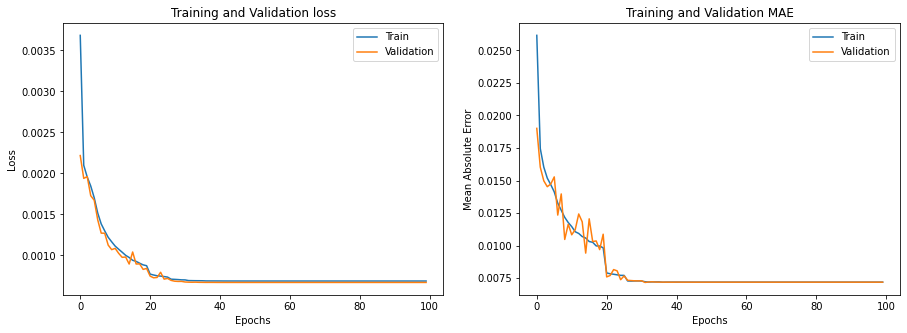

In [ ]:
plot_history(history.history)

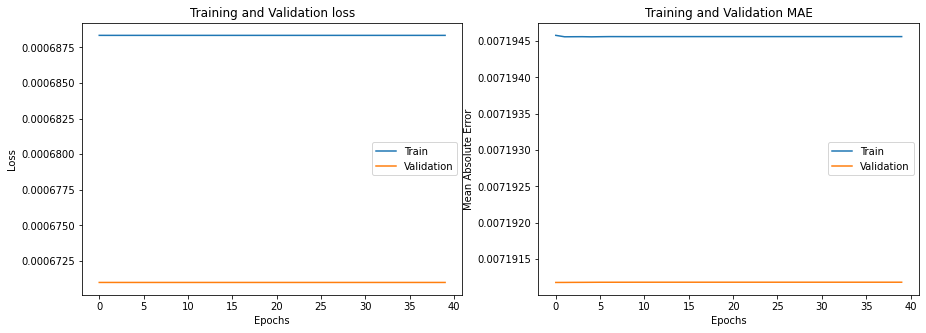

In [ ]:
plot_history(history.history, start=60)

#### 2.2.6.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 3s 22ms/step
Distance(m): [0.011111726896300253, 44.08433801684568]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390261,2.164419,126.292061,41.390242,2.164442,128.847477,2.740332
1,41.390253,2.164444,116.916134,41.390252,2.164498,77.760806,4.450859
2,41.390248,2.164467,106.363602,41.390255,2.164505,72.874040,3.213913
3,41.390248,2.164495,94.484103,41.390256,2.164510,69.448483,1.558820
4,41.390249,2.164535,85.243869,41.390257,2.164510,69.122152,2.174605
...,...,...,...,...,...,...,...
12915,41.391266,2.165883,159.782531,41.391251,2.165894,152.734246,1.860856
12916,41.391230,2.165899,161.327898,41.391186,2.165929,157.962653,5.505009
12917,41.391192,2.165914,157.092353,41.391120,2.165965,158.301657,8.971682
12918,41.391158,2.165926,153.510345,41.391090,2.165987,156.359249,9.106141


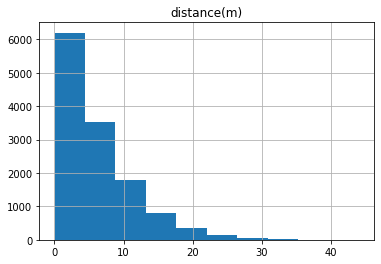

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.011111726896300253, 24.902640649897297]
Segundo 2: [0.04684972942429203, 23.77429009922213]
Segundo 3: [0.07821946734168758, 30.444225675739684]
Segundo 4: [0.1582135515816685, 35.69848720545068]
Segundo 5: [0.12453786545470058, 44.08433801684568]


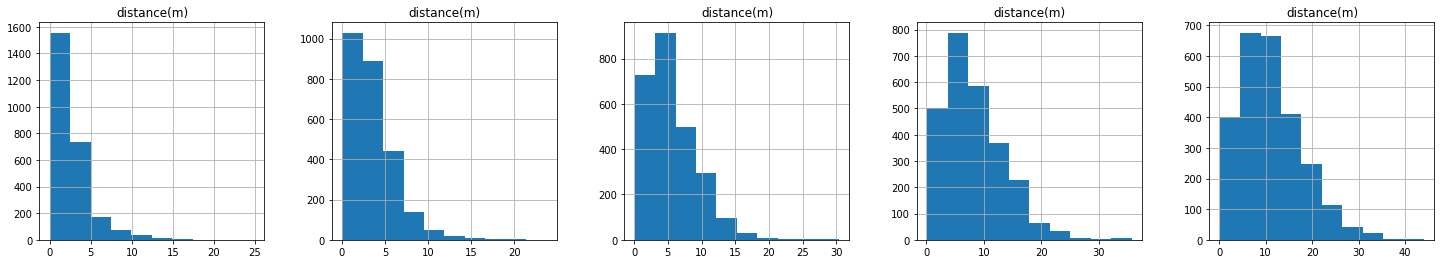

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390737,2.164779,164.275459,41.390738,2.164781,164.311173,2.727465
std,0.000773,0.001166,98.990638,0.000773,0.001168,99.848942,2.317533
min,41.387317,2.158383,6.467335,41.387357,2.158374,33.558601,0.011112
25%,41.390231,2.163957,60.717020,41.390241,2.163942,56.929802,1.264752
50%,41.390383,2.164486,138.035925,41.390385,2.164491,138.082230,2.086597
75%,41.391150,2.165610,228.203508,41.391154,2.165618,226.209520,3.373812
max,41.393960,2.167437,348.936611,41.393990,2.167493,325.723594,24.902641


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164785,162.822046,41.390741,2.164790,163.786712,3.652078
std,0.000771,0.001173,98.315603,0.000770,0.001179,100.746739,2.651066
min,41.387250,2.158272,4.386942,41.387281,2.158277,23.673287,0.046850
25%,41.390241,2.163879,61.857978,41.390247,2.163844,58.907796,1.789213
50%,41.390369,2.164522,140.009351,41.390368,2.164511,138.127025,3.007729
75%,41.391144,2.165652,227.719228,41.391147,2.165674,226.209520,4.899854
max,41.394006,2.167511,338.759603,41.394006,2.167493,325.723594,23.774290


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164790,163.119751,41.390746,2.164798,163.626592,5.701447
std,0.000768,0.001180,96.011246,0.000766,0.001191,101.859506,3.776799
min,41.387172,2.158178,-58.381481,41.387195,2.158180,5.714497,0.078219
25%,41.390252,2.163826,65.827406,41.390257,2.163762,58.287742,2.917913
50%,41.390360,2.164557,143.668052,41.390352,2.164545,138.222234,4.856882
75%,41.391144,2.165703,227.936372,41.391152,2.165733,226.209520,7.822397
max,41.394044,2.167602,336.297160,41.394021,2.167493,329.427144,30.444226


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164795,164.260277,41.390751,2.164803,163.617546,8.282719
std,0.000766,0.001187,92.837114,0.000763,0.001203,102.413872,5.199748
min,41.387083,2.158081,-115.731460,41.387111,2.158087,2.702005,0.158214
25%,41.390261,2.163785,73.751015,41.390277,2.163790,57.770335,4.342020
50%,41.390360,2.164585,147.099361,41.390339,2.164598,140.877186,7.274025
75%,41.391143,2.165728,227.723598,41.391141,2.165800,226.209520,11.202330
max,41.394100,2.167665,424.267616,41.394036,2.167506,343.864411,35.698487


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164798,166.455155,41.390755,2.164803,169.082277,11.276531
std,0.000765,0.001194,89.020508,0.000757,0.001216,103.386991,6.708745
min,41.386993,2.157971,-134.595760,41.387022,2.157973,0.437611,0.124538
25%,41.390269,2.163780,86.541566,41.390288,2.163845,68.784840,6.112469
50%,41.390360,2.164607,149.399430,41.390365,2.164600,163.397659,10.316794
75%,41.391141,2.165752,228.075874,41.391129,2.165866,232.136389,15.101060
max,41.394212,2.167758,480.617081,41.394120,2.167527,359.748667,44.084338


#### 2.2.6.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 20
FN: 980
Total no colision: 1000
FP: 26
TN: 974

Accuracy: 0.497
Precision: 0.43478260869565216
Recall: 0.02
F1 Score: 0.03824091778202677
Specificity: 0.974


## 2.3. Modelos Bidireccionales

In [ ]:
def make_lstm_bidirectional_model(units, in_steps, out_steps, in_features,
                                  out_features):
  lstm_model = Sequential()

  # Shape [batch, time, in_features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  lstm_model.add(Bidirectional(LSTM(units)))
  
  # Shape => [batch, out_steps*out_features].
  lstm_model.add(Dense(out_steps*out_features))

  # Shape => [batch, out_steps, out_features].
  lstm_model.add(Reshape([out_steps, out_features]))

  lstm_model.build(input_shape=(None, in_steps, in_features))
  lstm_model.summary()

  return lstm_model

### 2.3.1. Modelo LSTM Bidireccional (32 unidades)

#### 2.3.1.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "bidirectional", "LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_bidirectional_model(
    LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9216      
 l)                                                              
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 10,191
Trainable params: 10,191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 95s 27ms/step - loss: 0.0042 - mean_absolute_error: 0.0281 - val_loss: 0.0022 - val_mean_absolute_error: 0.0198 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 91s 27ms/st

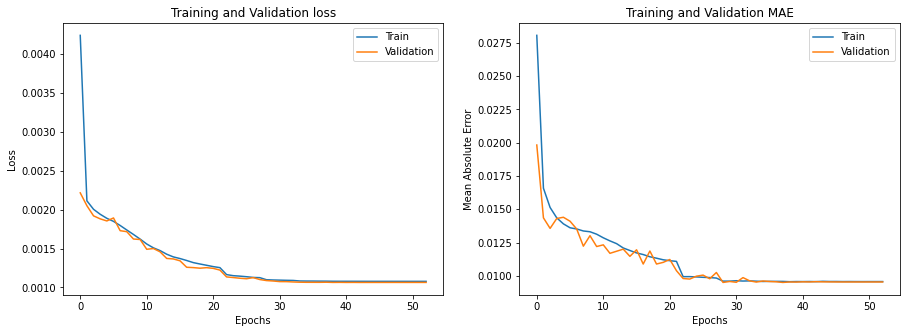

In [ ]:
plot_history(history.history)

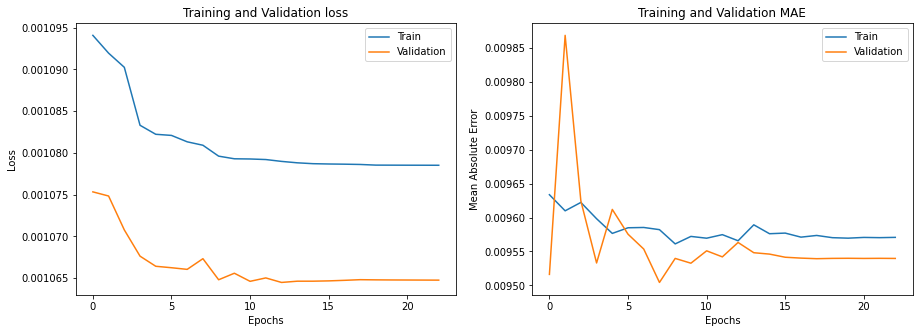

In [ ]:
plot_history(history.history, start=30)

#### 2.3.1.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 3s 12ms/step
Distance(m): [0.025977824247958622, 48.058150029517805]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390252,2.164430,132.552342,41.390242,2.164442,128.847477,1.449620
1,41.390240,2.164470,127.347538,41.390252,2.164498,77.760806,2.687531
2,41.390226,2.164496,122.356932,41.390255,2.164505,72.874040,3.209058
3,41.390221,2.164523,117.377458,41.390256,2.164510,69.448483,4.049095
4,41.390219,2.164553,113.550264,41.390257,2.164510,69.122152,5.488481
...,...,...,...,...,...,...,...
12915,41.391227,2.165867,149.072629,41.391251,2.165894,152.734246,3.526339
12916,41.391188,2.165906,146.872890,41.391186,2.165929,157.962653,1.999837
12917,41.391152,2.165922,144.894059,41.391120,2.165965,158.301657,5.023587
12918,41.391120,2.165937,143.138502,41.391090,2.165987,156.359249,5.355381


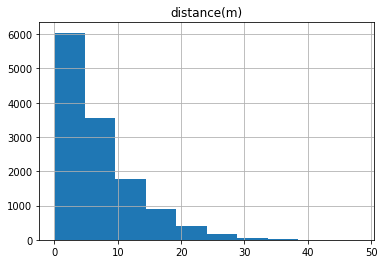

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.029682376884043297, 25.788620515025567]
Segundo 2: [0.025977824247958622, 29.566870977918636]
Segundo 3: [0.05793314396195144, 33.308365581459086]
Segundo 4: [0.13617776108722296, 39.61531959569416]
Segundo 5: [0.306011631918654, 48.058150029517805]


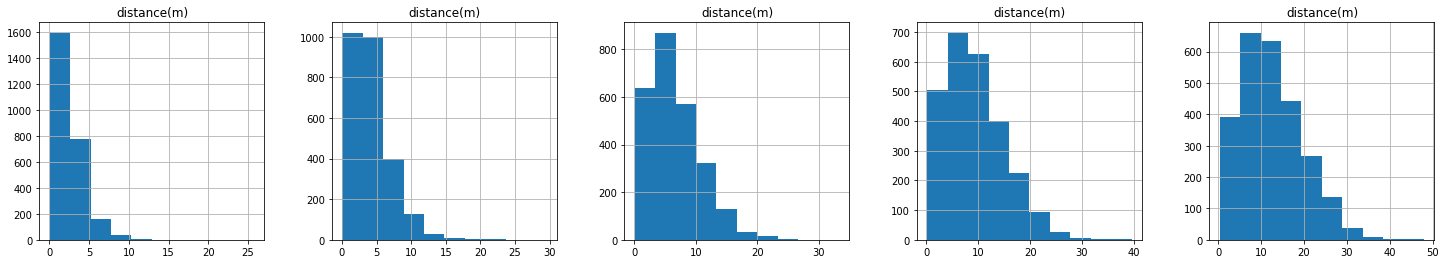

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390735,2.164779,163.776994,41.390738,2.164781,164.311173,2.517853
std,0.000774,0.001168,98.658106,0.000773,0.001168,99.848942,1.953330
min,41.387350,2.158409,23.821005,41.387357,2.158374,33.558601,0.029682
25%,41.390229,2.163955,63.003813,41.390241,2.163942,56.929802,1.133673
50%,41.390390,2.164476,137.526483,41.390385,2.164491,138.082230,2.062911
75%,41.391153,2.165623,227.298437,41.391154,2.165618,226.209520,3.395489
max,41.393930,2.167513,330.831959,41.393990,2.167493,325.723594,25.788621


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390739,2.164785,164.887764,41.390741,2.164790,163.786712,4.155913
std,0.000772,0.001174,96.272926,0.000770,0.001179,100.746739,2.836651
min,41.387284,2.158249,16.980808,41.387281,2.158277,23.673287,0.025978
25%,41.390234,2.163892,68.698044,41.390247,2.163844,58.907796,2.099803
50%,41.390377,2.164497,140.938941,41.390368,2.164511,138.127025,3.567145
75%,41.391145,2.165653,227.861752,41.391147,2.165674,226.209520,5.552354
max,41.393995,2.167521,333.445077,41.394006,2.167493,325.723594,29.566871


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164789,166.183297,41.390746,2.164798,163.626592,6.598189
std,0.000771,0.001181,93.875428,0.000766,0.001191,101.859506,4.196129
min,41.387185,2.158130,16.066095,41.387195,2.158180,5.714497,0.057933
25%,41.390238,2.163843,73.549430,41.390257,2.163762,58.287742,3.419561
50%,41.390368,2.164523,143.870981,41.390352,2.164545,138.222234,5.864830
75%,41.391146,2.165677,227.778070,41.391152,2.165733,226.209520,9.037649
max,41.394043,2.167548,331.783270,41.394021,2.167493,329.427144,33.308366


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390746,2.164791,167.567870,41.390751,2.164803,163.617546,9.348250
std,0.000768,0.001186,91.373671,0.000763,0.001203,102.413872,5.702531
min,41.387130,2.158040,19.395291,41.387111,2.158087,2.702005,0.136178
25%,41.390246,2.163793,80.314797,41.390277,2.163790,57.770335,4.939183
50%,41.390361,2.164547,146.165622,41.390339,2.164598,140.877186,8.469809
75%,41.391152,2.165702,228.086612,41.391141,2.165800,226.209520,12.844773
max,41.394097,2.167526,327.456640,41.394036,2.167506,343.864411,39.615320


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390750,2.164793,169.209694,41.390755,2.164803,169.082277,12.504253
std,0.000768,0.001193,88.907787,0.000757,0.001216,103.386991,7.198437
min,41.387031,2.157860,21.389510,41.387022,2.157973,0.437611,0.306012
25%,41.390260,2.163785,89.933801,41.390288,2.163845,68.784840,6.738180
50%,41.390367,2.164574,147.974298,41.390365,2.164600,163.397659,11.531632
75%,41.391156,2.165710,228.389219,41.391129,2.165866,232.136389,17.007690
max,41.394107,2.167531,330.891178,41.394120,2.167527,359.748667,48.058150


#### 2.3.1.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 39
FN: 961
Total no colision: 1000
FP: 26
TN: 974

Accuracy: 0.5065
Precision: 0.6
Recall: 0.039
F1 Score: 0.07323943661971831
Specificity: 0.974


### 2.3.2. Modelo LSTM Bidireccional (64 unidades)

#### 2.3.2.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "bidirectional", "LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_bidirectional_model(
    LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              34816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 36,751
Trainable params: 36,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 328s 96ms/step - loss: 0.0036 - mean_absolute_error: 0.0258 - val_loss: 0.0021 - val_mean_absolute_error: 0.0174 - lr: 0.0010
Epoch 2/100
3382/3382 [==============================] - 306s 90ms/

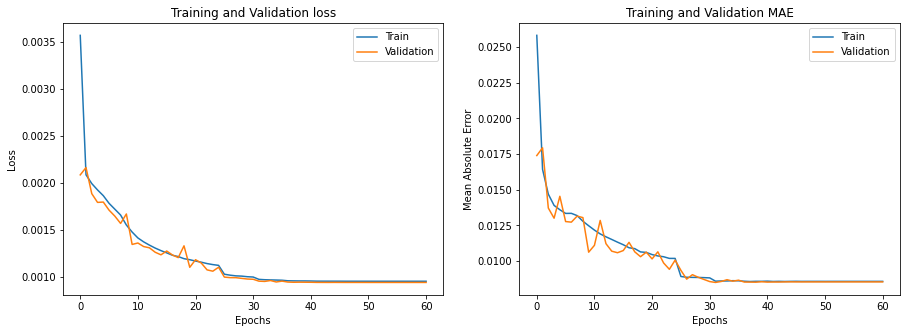

In [ ]:
plot_history(history.history)

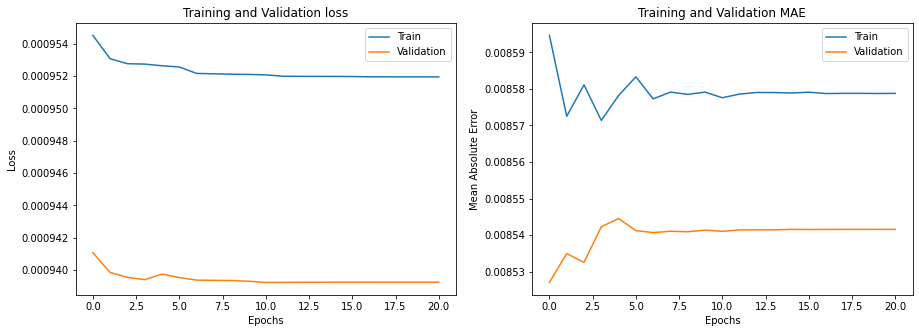

In [ ]:
plot_history(history.history, start=40)

#### 2.3.2.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 14ms/step
Distance(m): [0.01271496290547407, 47.18161396853697]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390253,2.164423,133.117850,41.390242,2.164442,128.847477,1.899712
1,41.390233,2.164455,127.557284,41.390252,2.164498,77.760806,4.189968
2,41.390217,2.164486,121.130788,41.390255,2.164505,72.874040,4.462806
3,41.390207,2.164516,115.083150,41.390256,2.164510,69.448483,5.490382
4,41.390201,2.164545,111.542098,41.390257,2.164510,69.122152,6.816038
...,...,...,...,...,...,...,...
12915,41.391220,2.165906,146.439910,41.391251,2.165894,152.734246,3.646107
12916,41.391182,2.165930,147.201499,41.391186,2.165929,157.962653,0.396828
12917,41.391146,2.165954,144.515210,41.391120,2.165965,158.301657,2.995585
12918,41.391125,2.165979,141.348183,41.391090,2.165987,156.359249,3.902937


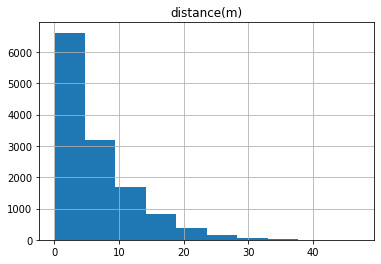

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.01271496290547407, 11.420966186089155]
Segundo 2: [0.04194456751141988, 16.992311407305206]
Segundo 3: [0.17705091474221157, 25.308780470499098]
Segundo 4: [0.05562914899571304, 39.19315205052798]
Segundo 5: [0.19076924141055612, 47.18161396853697]


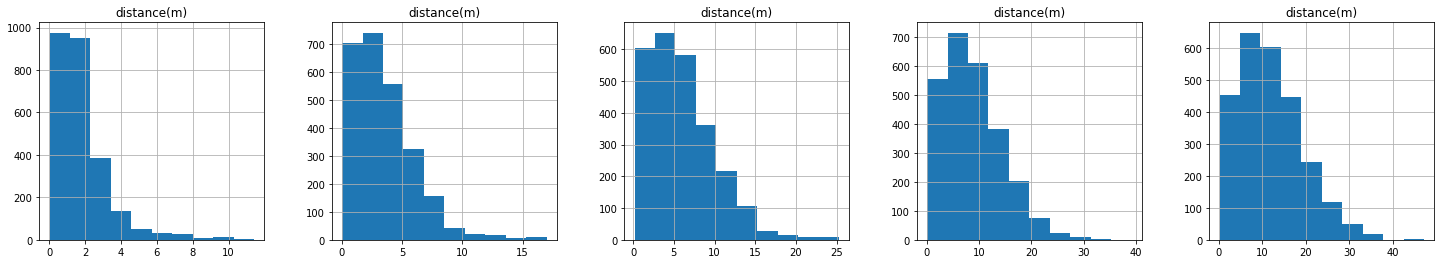

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390738,2.164779,163.593823,41.390738,2.164781,164.311173,1.831896
std,0.000774,0.001165,99.680598,0.000773,0.001168,99.848942,1.517354
min,41.387360,2.158378,14.022597,41.387357,2.158374,33.558601,0.012715
25%,41.390239,2.163942,59.764836,41.390241,2.163942,56.929802,0.813776
50%,41.390385,2.164480,138.562367,41.390385,2.164491,138.082230,1.484706
75%,41.391143,2.165617,228.161831,41.391154,2.165618,226.209520,2.315105
max,41.393974,2.167411,336.913644,41.393990,2.167493,325.723594,11.420966


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390741,2.164784,164.102066,41.390741,2.164790,163.786712,3.556884
std,0.000772,0.001173,97.553227,0.000770,0.001179,100.746739,2.553080
min,41.387271,2.158255,5.677796,41.387281,2.158277,23.673287,0.041945
25%,41.390239,2.163876,66.189977,41.390247,2.163844,58.907796,1.641250
50%,41.390376,2.164509,140.666611,41.390368,2.164511,138.127025,3.041911
75%,41.391140,2.165656,227.790140,41.391147,2.165674,226.209520,4.888793
max,41.394021,2.167469,341.684415,41.394006,2.167493,325.723594,16.992311


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390743,2.164788,165.121481,41.390746,2.164798,163.626592,6.011253
std,0.000770,0.001181,95.009806,0.000766,0.001191,101.859506,4.017518
min,41.387179,2.158115,-3.067380,41.387195,2.158180,5.714497,0.177051
25%,41.390241,2.163834,70.961101,41.390257,2.163762,58.287742,2.853919
50%,41.390366,2.164533,142.814294,41.390352,2.164545,138.222234,5.352897
75%,41.391141,2.165690,227.548579,41.391152,2.165733,226.209520,8.287742
max,41.394062,2.167526,330.401478,41.394021,2.167493,329.427144,25.308780


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164791,166.341876,41.390751,2.164803,163.617546,8.866088
std,0.000768,0.001189,92.427019,0.000763,0.001203,102.413872,5.609956
min,41.387086,2.157987,-5.376419,41.387111,2.158087,2.702005,0.055629
25%,41.390251,2.163799,80.377065,41.390277,2.163790,57.770335,4.462195
50%,41.390364,2.164563,145.428399,41.390339,2.164598,140.877186,7.968488
75%,41.391147,2.165720,227.969709,41.391141,2.165800,226.209520,12.191465
max,41.394110,2.167592,323.625295,41.394036,2.167506,343.864411,39.193152


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390750,2.164794,167.944487,41.390755,2.164803,169.082277,12.014262
std,0.000767,0.001196,89.655771,0.000757,0.001216,103.386991,7.178397
min,41.386980,2.157863,-0.337965,41.387022,2.157973,0.437611,0.190769
25%,41.390263,2.163787,92.481059,41.390288,2.163845,68.784840,6.250355
50%,41.390367,2.164588,148.235220,41.390365,2.164600,163.397659,11.136705
75%,41.391146,2.165734,228.001463,41.391129,2.165866,232.136389,16.424844
max,41.394195,2.167655,317.217322,41.394120,2.167527,359.748667,47.181614


#### 2.3.2.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 43
FN: 957
Total no colision: 1000
FP: 31
TN: 969

Accuracy: 0.506
Precision: 0.581081081081081
Recall: 0.043
F1 Score: 0.08007448789571693
Specificity: 0.969


## 2.4. Modelos Codificador-Decodificador

In [ ]:
def make_lstm_encdec_model(units, in_steps, out_steps, in_features, out_features):
  lstm_model = Sequential()

  # Shape [batch, time, in_features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  lstm_model.add(LSTM(units, input_shape=(in_steps, in_features)))
  lstm_model.add(RepeatVector(out_steps))

  lstm_model.add(LSTM(units, return_sequences=True))
  
  # Shape => [batch, out_steps*out_features].
  lstm_model.add(TimeDistributed(Dense(out_features)))

  lstm_model.summary()

  return lstm_model

### 2.4.1. Modelo LSTM Codificador-Decodificador (32 unidades)

#### 2.4.1.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "encoder_decoder", "LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_encdec_model(
    LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 repeat_vector (RepeatVector  (None, 5, 32)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             8320      
                                                                 
 time_distributed (TimeDistr  (None, 5, 3)             99        
 ibuted)                                                         
                                                                 
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [=============================

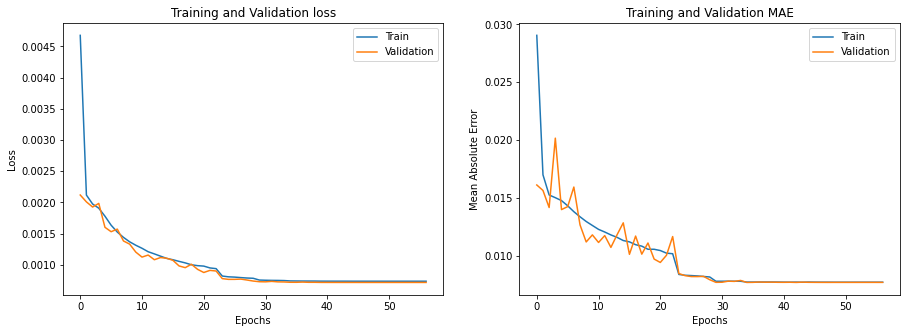

In [ ]:
plot_history(history.history)

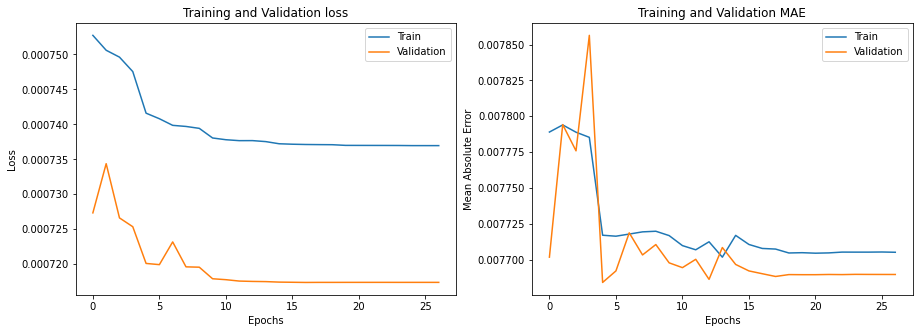

In [ ]:
plot_history(history.history, start=30)

#### 2.4.1.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 4s 13ms/step
Distance(m): [0.06715690707667746, 44.93186166136563]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390228,2.164446,129.180772,41.390242,2.164442,128.847477,1.685672
1,41.390227,2.164459,116.986827,41.390252,2.164498,77.760806,4.294397
2,41.390242,2.164475,104.593026,41.390255,2.164505,72.874040,2.853188
3,41.390283,2.164491,90.665541,41.390256,2.164510,69.448483,3.301569
4,41.390348,2.164520,75.120245,41.390257,2.164510,69.122152,10.161514
...,...,...,...,...,...,...,...
12915,41.391214,2.165921,147.415303,41.391251,2.165894,152.734246,4.759936
12916,41.391214,2.165957,149.414853,41.391186,2.165929,157.962653,3.909950
12917,41.391188,2.166021,149.779467,41.391120,2.165965,158.301657,8.822206
12918,41.391150,2.166051,149.103250,41.391090,2.165987,156.359249,8.536648


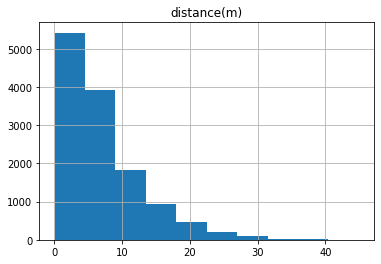

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.07157003932876933, 21.82808333766128]
Segundo 2: [0.10626132889321137, 20.99053162278659]
Segundo 3: [0.06715690707667746, 25.787077676006444]
Segundo 4: [0.1616552663733882, 36.936367797191515]
Segundo 5: [0.40909539619482455, 44.93186166136563]


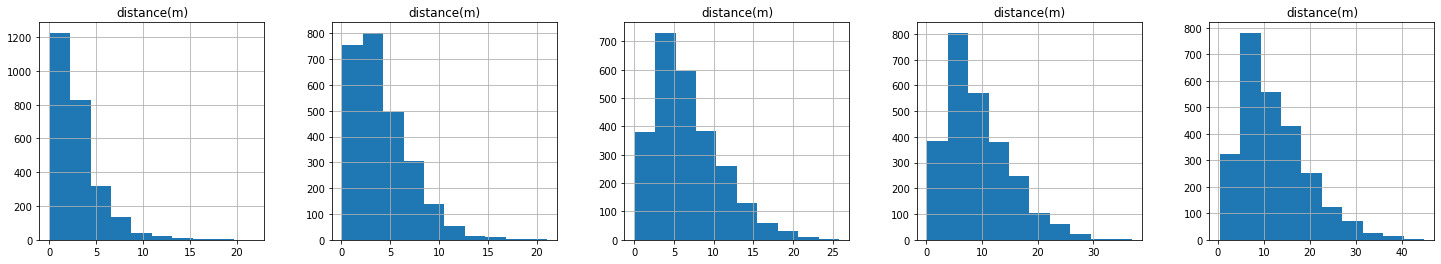

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390730,2.164780,163.841990,41.390738,2.164781,164.311173,3.035833
std,0.000774,0.001163,99.301641,0.000773,0.001168,99.848942,2.423383
min,41.387410,2.158473,20.919602,41.387357,2.158374,33.558601,0.071570
25%,41.390219,2.163945,60.060007,41.390241,2.163942,56.929802,1.377054
50%,41.390380,2.164499,138.778889,41.390385,2.164491,138.082230,2.360505
75%,41.391143,2.165602,228.475546,41.391154,2.165618,226.209520,3.978906
max,41.393976,2.167666,328.552261,41.393990,2.167493,325.723594,21.828083


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390739,2.164784,163.290259,41.390741,2.164790,163.786712,4.190118
std,0.000772,0.001175,97.942212,0.000770,0.001179,100.746739,2.908910
min,41.387284,2.158202,3.126741,41.387281,2.158277,23.673287,0.106261
25%,41.390238,2.163883,64.433664,41.390247,2.163844,58.907796,1.943086
50%,41.390365,2.164525,140.827440,41.390368,2.164511,138.127025,3.547026
75%,41.391134,2.165672,227.176327,41.391147,2.165674,226.209520,5.798795
max,41.394029,2.167559,358.919148,41.394006,2.167493,325.723594,20.990532


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164786,163.724068,41.390746,2.164798,163.626592,6.758451
std,0.000768,0.001173,95.730562,0.000766,0.001191,101.859506,4.222261
min,41.387215,2.158184,34.381995,41.387195,2.158180,5.714497,0.067157
25%,41.390248,2.163842,68.962036,41.390257,2.163762,58.287742,3.610461
50%,41.390370,2.164555,144.845811,41.390352,2.164545,138.222234,5.784361
75%,41.391145,2.165698,227.377408,41.391152,2.165733,226.209520,9.206091
max,41.394056,2.167450,353.579818,41.394021,2.167493,329.427144,25.787078


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390751,2.164787,164.704352,41.390751,2.164803,163.617546,9.364235
std,0.000765,0.001179,92.874437,0.000763,0.001203,102.413872,5.714256
min,41.387076,2.158033,35.055042,41.387111,2.158087,2.702005,0.161655
25%,41.390270,2.163821,73.024469,41.390277,2.163790,57.770335,5.084554
50%,41.390373,2.164578,148.103112,41.390339,2.164598,140.877186,8.042269
75%,41.391154,2.165723,227.587333,41.391141,2.165800,226.209520,12.718389
max,41.394063,2.167540,337.709113,41.394036,2.167506,343.864411,36.936368


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390757,2.164787,166.008238,41.390755,2.164803,169.082277,12.188125
std,0.000760,0.001186,89.815397,0.000757,0.001216,103.386991,7.283509
min,41.387027,2.157828,18.430941,41.387022,2.157973,0.437611,0.409095
25%,41.390289,2.163793,81.973163,41.390288,2.163845,68.784840,6.770604
50%,41.390382,2.164595,149.759916,41.390365,2.164600,163.397659,10.489882
75%,41.391149,2.165738,228.382875,41.391129,2.165866,232.136389,16.280152
max,41.394160,2.167588,332.720513,41.394120,2.167527,359.748667,44.931862


#### 2.4.1.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 29
FN: 971
Total no colision: 1000
FP: 26
TN: 974

Accuracy: 0.5015
Precision: 0.5272727272727272
Recall: 0.029
F1 Score: 0.05497630331753555
Specificity: 0.974


### 2.4.2. Modelo LSTM Codificador-Decodificador (64 unidades)

#### 2.4.2.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "encoder_decoder", "LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_encdec_model(
    LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             33024     
                                                                 
 time_distributed (TimeDistr  (None, 5, 3)             195       
 ibuted)                                                         
                                                                 
Total params: 50,627
Trainable params: 50,627
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [=============================

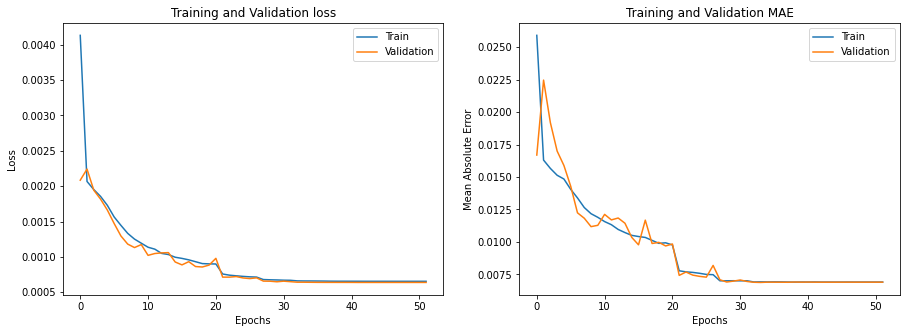

In [ ]:
plot_history(history.history)

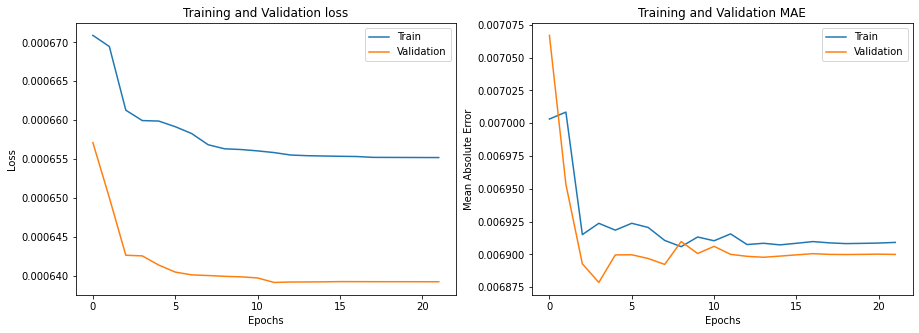

In [ ]:
plot_history(history.history, start=30)

#### 2.4.2.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 13ms/step
Distance(m): [0.018586843303902485, 41.67974950333675]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390232,2.164417,131.844288,41.390242,2.164442,128.847477,2.343965
1,41.390230,2.164462,122.273512,41.390252,2.164498,77.760806,3.842435
2,41.390241,2.164485,109.333324,41.390255,2.164505,72.874040,2.216964
3,41.390258,2.164551,91.445377,41.390256,2.164510,69.448483,3.449967
4,41.390283,2.164592,75.096502,41.390257,2.164510,69.122152,7.411876
...,...,...,...,...,...,...,...
12915,41.391274,2.165891,147.355717,41.391251,2.165894,152.734246,2.547883
12916,41.391238,2.165948,147.382141,41.391186,2.165929,157.962653,5.984096
12917,41.391212,2.165985,144.805031,41.391120,2.165965,158.301657,10.257234
12918,41.391187,2.166007,143.378098,41.391090,2.165987,156.359249,10.927773


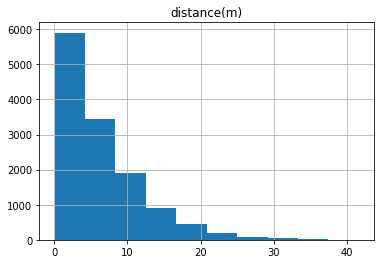

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.018586843303902485, 24.28951194388145]
Segundo 2: [0.09609173062702184, 38.60314893118741]
Segundo 3: [0.19016255361411974, 26.79670826992835]
Segundo 4: [0.1778952936630992, 35.03852291204848]
Segundo 5: [0.17561788874219317, 41.67974950333675]


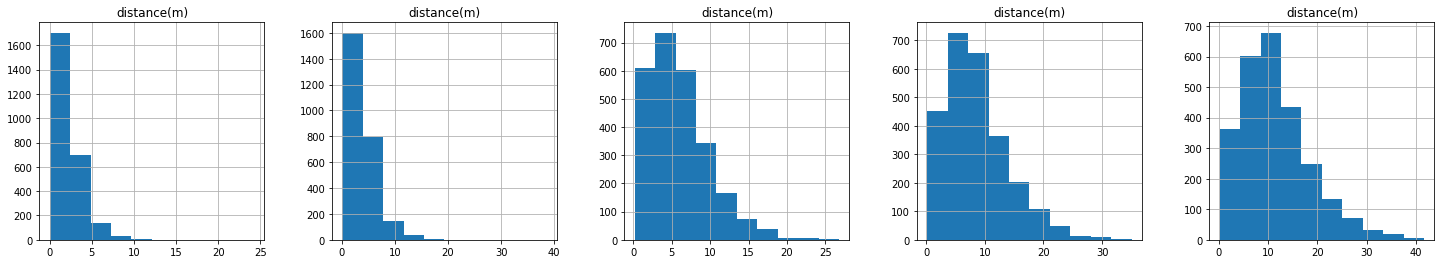

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390735,2.164777,163.396176,41.390738,2.164781,164.311173,2.196770
std,0.000771,0.001164,99.276919,0.000773,0.001168,99.848942,1.809290
min,41.387380,2.158367,37.326278,41.387357,2.158374,33.558601,0.018587
25%,41.390231,2.163976,60.735163,41.390241,2.163942,56.929802,0.959999
50%,41.390382,2.164483,138.909006,41.390385,2.164491,138.082230,1.736643
75%,41.391146,2.165607,225.867589,41.391154,2.165618,226.209520,2.885363
max,41.393926,2.167518,328.237607,41.393990,2.167493,325.723594,24.289512


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390741,2.164783,163.341340,41.390741,2.164790,163.786712,3.769331
std,0.000769,0.001173,98.358906,0.000770,0.001179,100.746739,2.651243
min,41.387269,2.158248,34.394432,41.387281,2.158277,23.673287,0.096092
25%,41.390244,2.163897,60.485460,41.390247,2.163844,58.907796,1.938158
50%,41.390372,2.164521,141.586339,41.390368,2.164511,138.127025,3.177193
75%,41.391138,2.165668,227.954222,41.391147,2.165674,226.209520,4.984786
max,41.393974,2.167403,332.165228,41.394006,2.167493,325.723594,38.603149


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164790,163.360735,41.390746,2.164798,163.626592,6.007228
std,0.000768,0.001182,96.448789,0.000766,0.001191,101.859506,3.886322
min,41.387214,2.158119,30.899283,41.387195,2.158180,5.714497,0.190163
25%,41.390257,2.163838,63.784946,41.390257,2.163762,58.287742,2.963018
50%,41.390358,2.164559,143.816981,41.390352,2.164545,138.222234,5.321692
75%,41.391143,2.165709,227.922675,41.391152,2.165733,226.209520,8.130521
max,41.394009,2.167492,324.869769,41.394021,2.167493,329.427144,26.796708


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164792,163.752904,41.390751,2.164803,163.617546,8.656413
std,0.000765,0.001185,93.792535,0.000763,0.001203,102.413872,5.338345
min,41.387106,2.157926,30.766546,41.387111,2.158087,2.702005,0.177895
25%,41.390270,2.163786,67.205364,41.390277,2.163790,57.770335,4.596715
50%,41.390362,2.164593,146.313568,41.390339,2.164598,140.877186,7.699315
75%,41.391143,2.165720,228.040916,41.391141,2.165800,226.209520,11.348011
max,41.394075,2.167553,325.545666,41.394036,2.167506,343.864411,35.038523


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390751,2.164794,165.854260,41.390755,2.164803,169.082277,11.547747
std,0.000762,0.001189,90.239428,0.000757,0.001216,103.386991,6.940667
min,41.387056,2.157881,35.762084,41.387022,2.157973,0.437611,0.175618
25%,41.390278,2.163790,78.633709,41.390288,2.163845,68.784840,6.245253
50%,41.390365,2.164613,149.695752,41.390365,2.164600,163.397659,10.548443
75%,41.391144,2.165742,226.873205,41.391129,2.165866,232.136389,15.199089
max,41.394114,2.167600,326.367824,41.394120,2.167527,359.748667,41.679750


#### 2.4.2.3. Métricas del modelo

In [ ]:
# Load fitted model 
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 29
FN: 971
Total no colision: 1000
FP: 23
TN: 977

Accuracy: 0.503
Precision: 0.5576923076923077
Recall: 0.029
F1 Score: 0.05513307984790875
Specificity: 0.977


## 2.5. Modelos con mecanismo de atención

In [ ]:
def make_lstm_attention_model(lstm_units, attention_units, in_steps, out_steps,
                              in_features, out_features):
  lstm_model = Sequential()

  # Shape [batch, time, in_features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  lstm_model.add(LSTM(
      lstm_units, input_shape=(in_steps, in_features), return_sequences=True))
  
  lstm_model.add(Attention(attention_units))
  
  # Shape => [batch, out_steps*out_features].
  lstm_model.add(Dense(out_steps*out_features))

  # Shape => [batch, out_steps, out_features].
  lstm_model.add(Reshape([out_steps, out_features]))

  lstm_model.summary()

  return lstm_model

### 2.5.1. Modelo LSTM (64 unidades) con mecanismo de atención (32 unidades)

#### 2.5.1.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "attention",
                            "LSTM_64units_Attention_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64
ATTENTION_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_attention_model(
    LSTM_UNITS, ATTENTION_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            17408     
                                                                 
 attention (Attention)       (None, 32)                8192      
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 26,095
Trainable params: 26,095
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 180s 53ms/step - loss: 0.0039 - mean_absolute_error: 0.0252 - val_loss: 0.0021 - val_mean_absolute_error: 0.0156 - lr: 0.0010
E

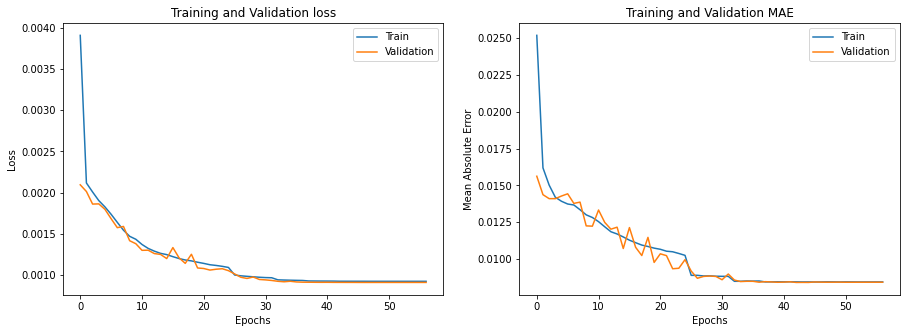

In [ ]:
plot_history(history.history)

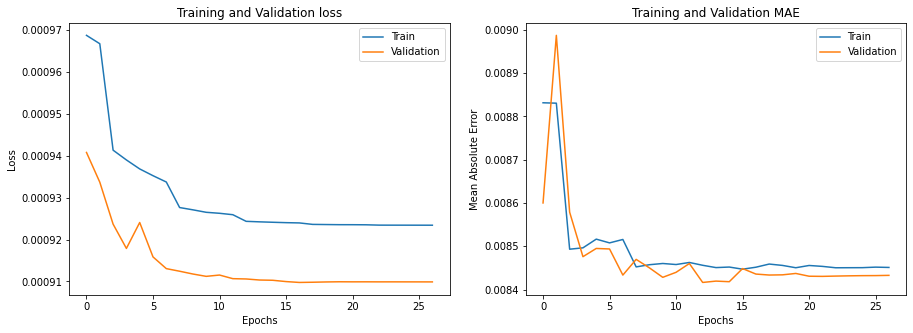

In [ ]:
plot_history(history.history, start=30)

#### 2.5.1.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 1s 12ms/step
Distance(m): [0.041805959307232056, 38.15607455858188]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390254,2.164436,134.062975,41.390242,2.164442,128.847477,1.413833
1,41.390231,2.164467,128.278134,41.390252,2.164498,77.760806,3.423099
2,41.390208,2.164504,122.481823,41.390255,2.164505,72.874040,5.177865
3,41.390194,2.164535,116.175481,41.390256,2.164510,69.448483,7.294188
4,41.390183,2.164569,111.414010,41.390257,2.164510,69.122152,9.515205
...,...,...,...,...,...,...,...
12915,41.391293,2.165865,155.616341,41.391251,2.165894,152.734246,5.268527
12916,41.391249,2.165925,147.006366,41.391186,2.165929,157.962653,7.050698
12917,41.391226,2.165938,139.042959,41.391120,2.165965,158.301657,11.987891
12918,41.391220,2.165956,132.373916,41.391090,2.165987,156.359249,14.658590


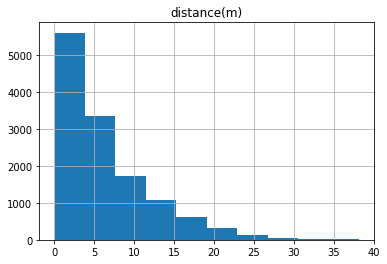

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.04504412162087849, 12.567354302767443]
Segundo 2: [0.06272011483876594, 18.18768005462567]
Segundo 3: [0.10422533935963141, 24.582055101658813]
Segundo 4: [0.10062953184282164, 31.721611559430517]
Segundo 5: [0.041805959307232056, 38.15607455858188]


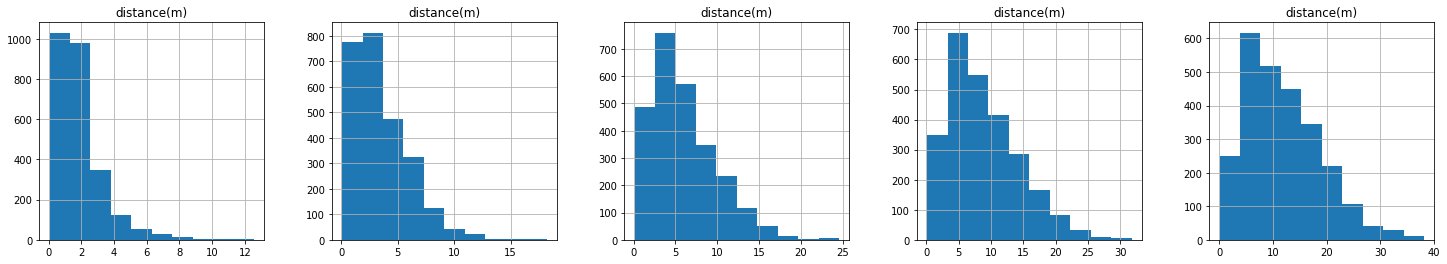

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390738,2.164781,163.398805,41.390738,2.164781,164.311173,1.911479
std,0.000773,0.001169,99.765179,0.000773,0.001168,99.848942,1.485504
min,41.387330,2.158278,3.174566,41.387357,2.158374,33.558601,0.045044
25%,41.390241,2.163948,59.717657,41.390241,2.163942,56.929802,0.909550
50%,41.390385,2.164491,139.180573,41.390385,2.164491,138.082230,1.568979
75%,41.391148,2.165614,228.908308,41.391154,2.165618,226.209520,2.413769
max,41.393975,2.167468,334.188538,41.393990,2.167493,325.723594,12.567354


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390742,2.164787,163.809862,41.390741,2.164790,163.786712,3.532210
std,0.000771,0.001176,97.893453,0.000770,0.001179,100.746739,2.511599
min,41.387267,2.158229,-15.413467,41.387281,2.158277,23.673287,0.062720
25%,41.390242,2.163887,65.801532,41.390247,2.163844,58.907796,1.673608
50%,41.390372,2.164522,141.927192,41.390368,2.164511,138.127025,2.945810
75%,41.391144,2.165653,227.971897,41.391147,2.165674,226.209520,4.846500
max,41.394006,2.167463,352.864282,41.394006,2.167493,325.723594,18.187680


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390744,2.164791,165.168935,41.390746,2.164798,163.626592,6.001031
std,0.000769,0.001183,95.339577,0.000766,0.001191,101.859506,3.833579
min,41.387211,2.158092,-20.828540,41.387195,2.158180,5.714497,0.104225
25%,41.390246,2.163832,70.775975,41.390257,2.163762,58.287742,3.064640
50%,41.390364,2.164549,144.398738,41.390352,2.164545,138.222234,5.200535
75%,41.391151,2.165691,228.250746,41.391152,2.165733,226.209520,8.270624
max,41.394026,2.167541,354.802295,41.394021,2.167493,329.427144,24.582055


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164794,166.642703,41.390751,2.164803,163.617546,8.833859
std,0.000767,0.001191,92.747624,0.000763,0.001203,102.413872,5.408457
min,41.387124,2.158006,-24.951949,41.387111,2.158087,2.702005,0.100630
25%,41.390256,2.163798,78.447415,41.390277,2.163790,57.770335,4.566191
50%,41.390358,2.164569,146.606612,41.390339,2.164598,140.877186,7.825391
75%,41.391159,2.165722,228.401784,41.391141,2.165800,226.209520,12.171830
max,41.394096,2.167560,339.851443,41.394036,2.167506,343.864411,31.721612


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390750,2.164796,168.480045,41.390755,2.164803,169.082277,11.874978
std,0.000764,0.001197,89.906909,0.000757,0.001216,103.386991,6.920961
min,41.387063,2.157909,-27.002630,41.387022,2.157973,0.437611,0.041806
25%,41.390269,2.163784,90.289125,41.390288,2.163845,68.784840,6.409126
50%,41.390362,2.164590,149.198922,41.390365,2.164600,163.397659,10.666400
75%,41.391152,2.165744,227.841096,41.391129,2.165866,232.136389,16.397926
max,41.394169,2.167591,323.125256,41.394120,2.167527,359.748667,38.156075


#### 2.5.1.3. Métricas del modelo

In [ ]:
# Load fitted model
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(
    MODEL_FILE, custom_objects={'Attention': Attention})

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 33
FN: 967
Total no colision: 1000
FP: 20
TN: 980

Accuracy: 0.5065
Precision: 0.6226415094339622
Recall: 0.033
F1 Score: 0.06267806267806268
Specificity: 0.98


### 2.5.2. Modelo LSTM (64 unidades) con mecanismo de atención (64 unidades)

#### 2.5.2.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "attention",
                            "LSTM_64units_Attention_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64
ATTENTION_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_attention_model(
    LSTM_UNITS, ATTENTION_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 64)            17408     
                                                                 
 attention_1 (Attention)     (None, 64)                12288     
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
 reshape_1 (Reshape)         (None, 5, 3)              0         
                                                                 
Total params: 30,671
Trainable params: 30,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 192s 56ms/step - loss: 0.0036 - mean_absolute_error: 0.0241 - val_loss: 0.0022 - val_mean_absolute_error: 0.0178 - lr: 0.0010

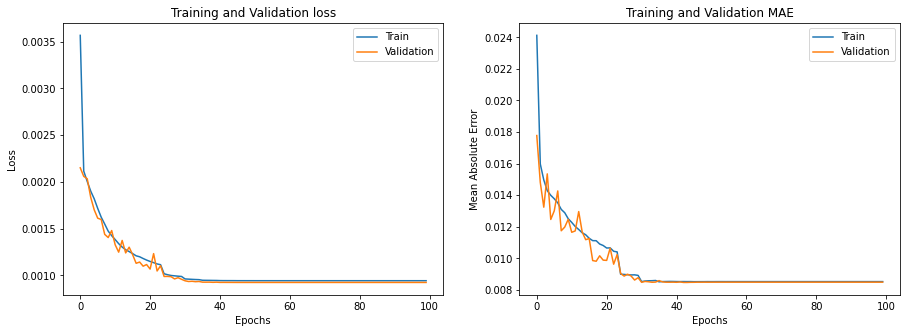

In [ ]:
plot_history(history.history)

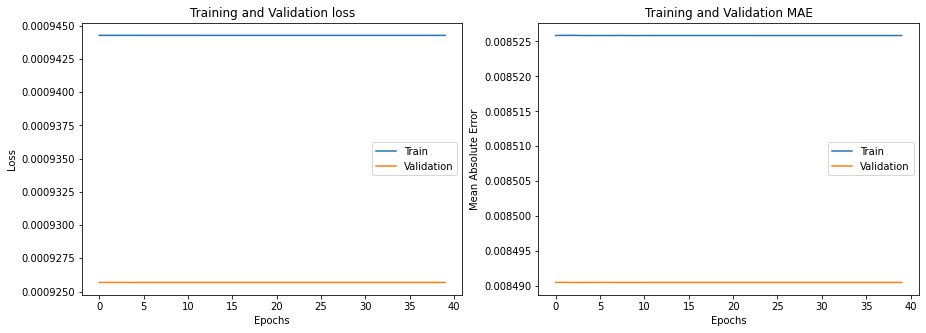

In [ ]:
plot_history(history.history, start=60)

#### 2.5.2.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 13ms/step
Distance(m): [0.024933199462268178, 48.62469677062062]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390232,2.164440,132.347407,41.390242,2.164442,128.847477,1.161878
1,41.390216,2.164467,128.546233,41.390252,2.164498,77.760806,4.712397
2,41.390198,2.164499,124.295707,41.390255,2.164505,72.874040,6.293197
3,41.390194,2.164527,119.724806,41.390256,2.164510,69.448483,7.063060
4,41.390190,2.164560,116.055764,41.390257,2.164510,69.122152,8.492633
...,...,...,...,...,...,...,...
12915,41.391244,2.165909,149.434968,41.391251,2.165894,152.734246,1.534024
12916,41.391210,2.165963,144.061956,41.391186,2.165929,157.962653,3.891481
12917,41.391189,2.166032,137.503730,41.391120,2.165965,158.301657,9.476652
12918,41.391168,2.166089,131.567856,41.391090,2.165987,156.359249,12.168390


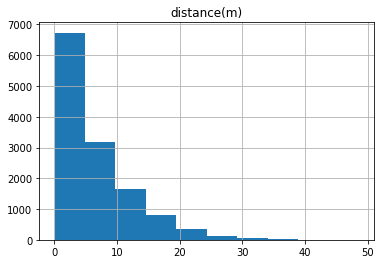

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.024933199462268178, 12.125212445039361]
Segundo 2: [0.046383994116845344, 18.27657624141775]
Segundo 3: [0.046654092103960966, 27.694260327608884]
Segundo 4: [0.19088944665652058, 41.06751142279802]
Segundo 5: [0.0496103628730948, 48.62469677062062]


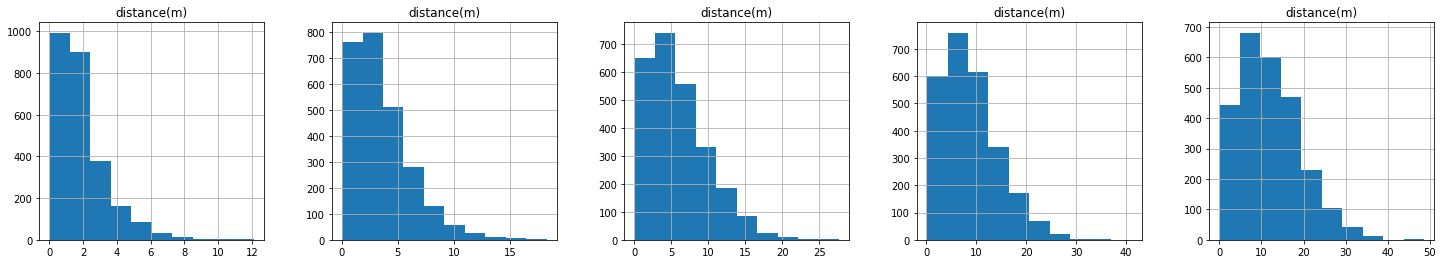

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390737,2.164779,163.293654,41.390738,2.164781,164.311173,1.946969
std,0.000775,0.001166,100.142086,0.000773,0.001168,99.848942,1.520002
min,41.387368,2.158410,-11.301731,41.387357,2.158374,33.558601,0.024933
25%,41.390236,2.163950,60.147712,41.390241,2.163942,56.929802,0.891879
50%,41.390390,2.164485,138.721136,41.390385,2.164491,138.082230,1.508311
75%,41.391150,2.165596,228.932787,41.391154,2.165618,226.209520,2.532366
max,41.393980,2.167462,336.270236,41.393990,2.167493,325.723594,12.125212


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164785,164.142125,41.390741,2.164790,163.786712,3.633272
std,0.000772,0.001174,98.013075,0.000770,0.001179,100.746739,2.654722
min,41.387285,2.158281,-17.634834,41.387281,2.158277,23.673287,0.046384
25%,41.390236,2.163875,64.555760,41.390247,2.163844,58.907796,1.647195
50%,41.390372,2.164516,141.495109,41.390368,2.164511,138.127025,3.038678
75%,41.391140,2.165645,227.774070,41.391147,2.165674,226.209520,4.965852
max,41.394010,2.167502,352.447911,41.394006,2.167493,325.723594,18.276576


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390742,2.164789,165.653322,41.390746,2.164798,163.626592,5.983623
std,0.000769,0.001183,95.310872,0.000766,0.001191,101.859506,4.102142
min,41.387198,2.158132,-19.351427,41.387195,2.158180,5.714497,0.046654
25%,41.390241,2.163825,70.203642,41.390257,2.163762,58.287742,2.785897
50%,41.390361,2.164538,144.116929,41.390352,2.164545,138.222234,5.176067
75%,41.391150,2.165692,228.525135,41.391152,2.165733,226.209520,8.278714
max,41.394037,2.167550,352.404252,41.394021,2.167493,329.427144,27.694260


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164793,167.174639,41.390751,2.164803,163.617546,8.869211
std,0.000768,0.001190,92.677952,0.000763,0.001203,102.413872,5.631775
min,41.387110,2.158013,-20.595197,41.387111,2.158087,2.702005,0.190889
25%,41.390249,2.163797,81.120704,41.390277,2.163790,57.770335,4.508928
50%,41.390361,2.164565,147.050791,41.390339,2.164598,140.877186,7.934414
75%,41.391151,2.165719,228.895756,41.391141,2.165800,226.209520,12.165589
max,41.394054,2.167651,339.223904,41.394036,2.167506,343.864411,41.067511


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390748,2.164795,168.950425,41.390755,2.164803,169.082277,11.950030
std,0.000765,0.001198,89.951933,0.000757,0.001216,103.386991,7.251050
min,41.387004,2.157868,-17.308293,41.387022,2.157973,0.437611,0.049610
25%,41.390264,2.163792,93.291110,41.390288,2.163845,68.784840,6.161092
50%,41.390367,2.164590,149.301750,41.390365,2.164600,163.397659,11.033238
75%,41.391144,2.165742,229.356034,41.391129,2.165866,232.136389,16.530788
max,41.394118,2.167709,322.859253,41.394120,2.167527,359.748667,48.624697


#### 2.5.2.3. Métricas del modelo

In [ ]:
# Load fitted model
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(
    MODEL_FILE, custom_objects={'Attention': Attention})

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 33
FN: 967
Total no colision: 1000
FP: 22
TN: 978

Accuracy: 0.5055
Precision: 0.6
Recall: 0.033
F1 Score: 0.06255924170616114
Specificity: 0.978


### 2.5.3. Modelo LSTM (32 unidades) con mecanismo de atención (32 unidades)

#### 2.5.3.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "attention",
                            "LSTM_32units_Attention_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32
ATTENTION_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_attention_model(
    LSTM_UNITS, ATTENTION_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4608      
                                                                 
 attention (Attention)       (None, 32)                3072      
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 8,175
Trainable params: 8,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 110s 32ms/step - loss: 0.0051 - mean_absolute_error: 0.0283 - val_loss: 0.0022 - val_mean_absolute_error: 0.0194 - lr: 0.0010
Epo

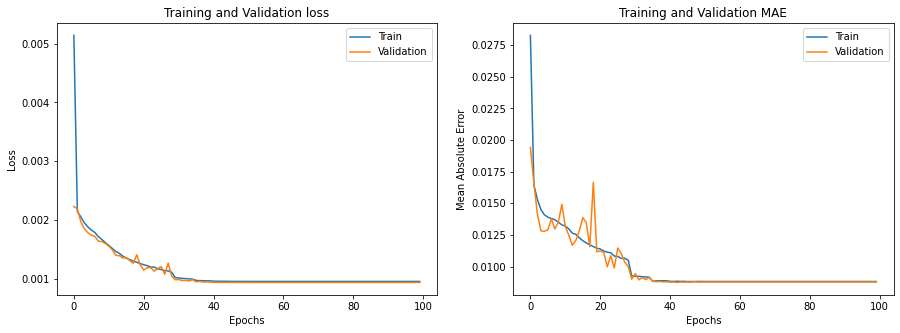

In [ ]:
plot_history(history.history)

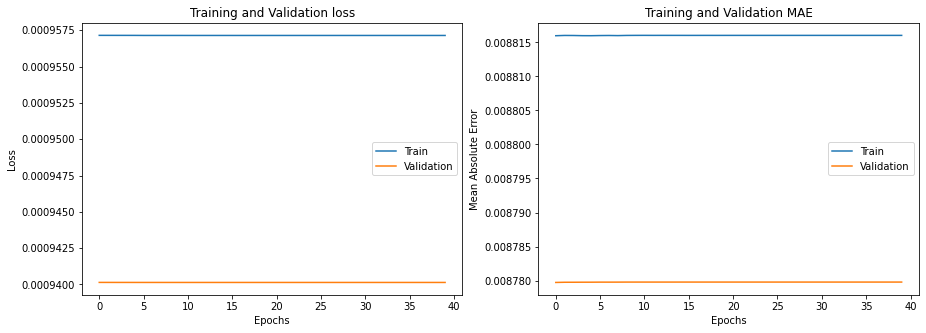

In [ ]:
plot_history(history.history, start=60)

#### 2.5.3.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 10ms/step
Distance(m): [0.05630273968344267, 61.9637033317993]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390265,2.164426,131.356250,41.390242,2.164442,128.847477,2.821522
1,41.390250,2.164442,127.746630,41.390252,2.164498,77.760806,4.622074
2,41.390240,2.164461,123.773717,41.390255,2.164505,72.874040,4.018616
3,41.390232,2.164480,119.873249,41.390256,2.164510,69.448483,3.633367
4,41.390226,2.164493,116.917148,41.390257,2.164510,69.122152,3.718821
...,...,...,...,...,...,...,...
12915,41.391240,2.165887,142.338105,41.391251,2.165894,152.734246,1.353364
12916,41.391219,2.165922,145.725443,41.391186,2.165929,157.962653,3.822997
12917,41.391204,2.165965,149.345320,41.391120,2.165965,158.301657,9.241996
12918,41.391191,2.165994,150.088242,41.391090,2.165987,156.359249,11.314016


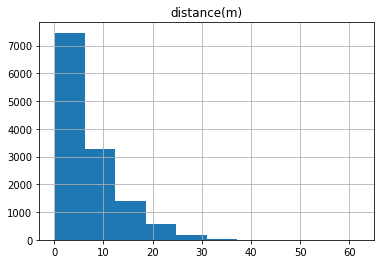

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.0633986742207625, 26.6507088114725]
Segundo 2: [0.11542943723595162, 28.794775807855803]
Segundo 3: [0.16447282473824595, 39.8515970720767]
Segundo 4: [0.09255895206012309, 48.12243658110964]
Segundo 5: [0.05630273968344267, 61.9637033317993]


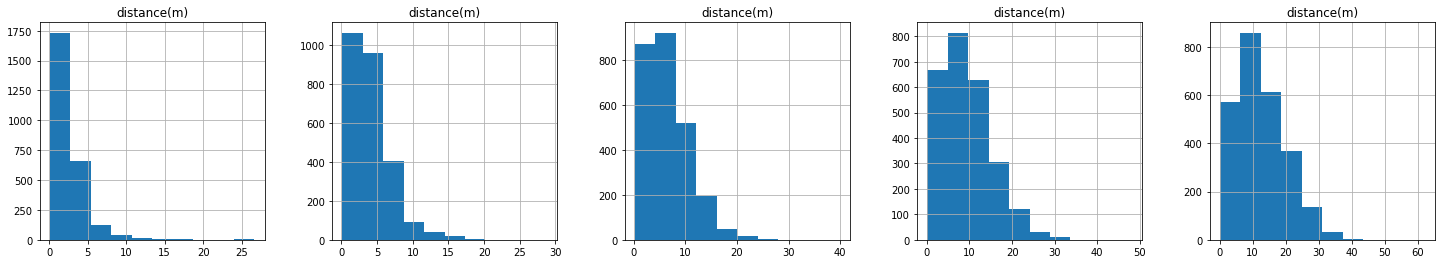

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390740,2.164779,163.589309,41.390738,2.164781,164.311173,2.551187
std,0.000772,0.001162,99.604584,0.000773,0.001168,99.848942,2.324789
min,41.387390,2.158408,10.530676,41.387357,2.158374,33.558601,0.063399
25%,41.390237,2.163945,57.305787,41.390241,2.163942,56.929802,1.176934
50%,41.390391,2.164481,138.950491,41.390385,2.164491,138.082230,2.006099
75%,41.391155,2.165591,228.507238,41.391154,2.165618,226.209520,3.204166
max,41.393917,2.167307,331.777220,41.393990,2.167493,325.723594,26.650709


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390742,2.164783,163.754642,41.390741,2.164790,163.786712,4.093306
std,0.000770,0.001172,97.794120,0.000770,0.001179,100.746739,2.882438
min,41.387277,2.158287,22.937969,41.387281,2.158277,23.673287,0.115429
25%,41.390245,2.163880,63.377163,41.390247,2.163844,58.907796,1.947759
50%,41.390376,2.164502,140.855113,41.390368,2.164511,138.127025,3.508888
75%,41.391147,2.165645,229.109618,41.391147,2.165674,226.209520,5.541612
max,41.393995,2.167370,332.032503,41.394006,2.167493,325.723594,28.794776


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164785,164.749806,41.390746,2.164798,163.626592,6.531278
std,0.000766,0.001183,95.523502,0.000766,0.001191,101.859506,4.216004
min,41.387180,2.158157,20.349466,41.387195,2.158180,5.714497,0.164473
25%,41.390253,2.163841,71.372529,41.390257,2.163762,58.287742,3.335239
50%,41.390368,2.164525,142.895110,41.390352,2.164545,138.222234,5.721493
75%,41.391144,2.165697,228.622032,41.391152,2.165733,226.209520,8.943145
max,41.394059,2.167497,334.945847,41.394021,2.167493,329.427144,39.851597


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390746,2.164788,166.129030,41.390751,2.164803,163.617546,9.380883
std,0.000765,0.001191,93.105168,0.000763,0.001203,102.413872,5.807653
min,41.387083,2.158061,17.042374,41.387111,2.158087,2.702005,0.092559
25%,41.390259,2.163797,78.682400,41.390277,2.163790,57.770335,4.822896
50%,41.390368,2.164551,145.257244,41.390339,2.164598,140.877186,8.485574
75%,41.391150,2.165716,228.685821,41.391141,2.165800,226.209520,12.921231
max,41.394104,2.167499,333.062218,41.394036,2.167506,343.864411,48.122437


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390749,2.164788,167.793367,41.390755,2.164803,169.082277,12.508507
std,0.000762,0.001200,90.439798,0.000757,0.001216,103.386991,7.452016
min,41.387000,2.157924,18.775356,41.387022,2.157973,0.437611,0.056303
25%,41.390271,2.163794,89.016003,41.390288,2.163845,68.784840,6.775441
50%,41.390378,2.164564,147.971791,41.390365,2.164600,163.397659,11.258413
75%,41.391144,2.165732,228.033050,41.391129,2.165866,232.136389,17.381616
max,41.394146,2.167496,376.302405,41.394120,2.167527,359.748667,61.963703


#### 2.5.3.3. Métricas del modelo

In [ ]:
# Load fitted model
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(
    MODEL_FILE, custom_objects={'Attention': Attention})

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 25
FN: 975
Total no colision: 1000
FP: 28
TN: 972

Accuracy: 0.4985
Precision: 0.4716981132075472
Recall: 0.025
F1 Score: 0.04748338081671415
Specificity: 0.972


### 2.5.4. Modelo LSTM (32 unidades) con mecanismo de atención (64 unidades)

#### 2.5.4.1. Creación y entrenamiento de la red

In [ ]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "attention",
                            "LSTM_32units_Attention_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32
ATTENTION_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_attention_model(
    LSTM_UNITS, ATTENTION_UNITS, INPUT_WIDTH, OUTPUT_WIDTH, len(INPUT_COL),
    len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4608      
                                                                 
 attention (Attention)       (None, 64)                5120      
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 reshape (Reshape)           (None, 5, 3)              0         
                                                                 
Total params: 10,703
Trainable params: 10,703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3382/3382 [==============================] - 144s 42ms/step - loss: 0.0040 - mean_absolute_error: 0.0259 - val_loss: 0.0022 - val_mean_absolute_error: 0.0188 - lr: 0.0010
E

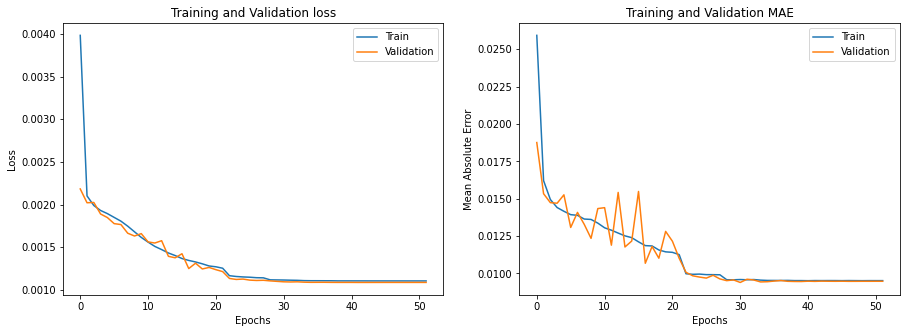

In [ ]:
plot_history(history.history)

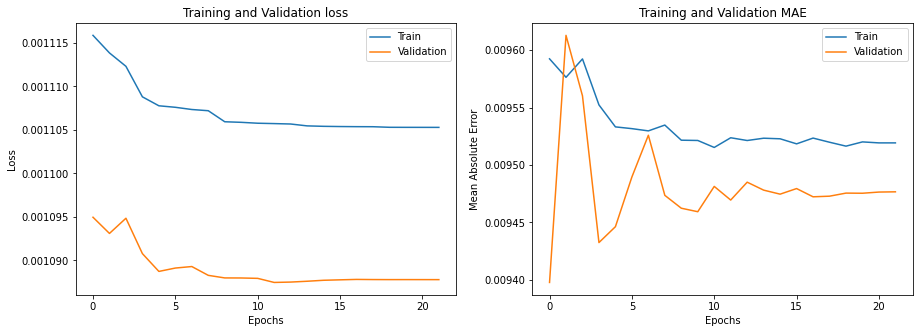

In [ ]:
plot_history(history.history, start=30)

#### 2.5.4.2. Predicción de la red

In [ ]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

81/81 [==============================] - 2s 10ms/step
Distance(m): [0.01805648536168601, 42.27645525758637]


,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
0,41.390259,2.164430,131.618560,41.390242,2.164442,128.847477,2.111723
1,41.390242,2.164460,129.329713,41.390252,2.164498,77.760806,3.361780
2,41.390225,2.164484,127.322282,41.390255,2.164505,72.874040,3.690638
3,41.390213,2.164512,124.770368,41.390256,2.164510,69.448483,4.798120
4,41.390205,2.164539,123.409073,41.390257,2.164510,69.122152,6.173781
...,...,...,...,...,...,...,...
12915,41.391274,2.165889,144.080846,41.391251,2.165894,152.734246,2.529345
12916,41.391233,2.165938,145.092805,41.391186,2.165929,157.962653,5.346695
12917,41.391194,2.165982,146.170140,41.391120,2.165965,158.301657,8.279605
12918,41.391177,2.166012,146.389489,41.391090,2.165987,156.359249,9.884195


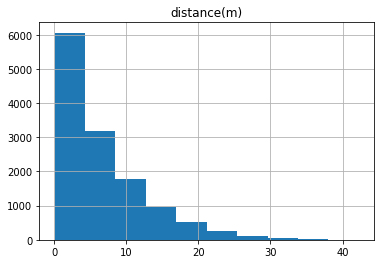

In [ ]:
df_pred.hist('distance(m)')
plt.show()

In [ ]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
  if i%5 == 0:
    list_1seg[i] = True
  elif i%5 == 1:
    list_2seg[i] = True
  elif i%5 == 2:
    list_3seg[i] = True
  elif i%5 == 3:
    list_4seg[i] = True
  elif i%5 == 4:
    list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [ ]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.01805648536168601, 18.498930396736878]
Segundo 2: [0.04232281143832279, 21.504474123371317]
Segundo 3: [0.062044228457235916, 27.843262373534262]
Segundo 4: [0.023453567057421434, 34.296145501372486]
Segundo 5: [0.09700610334957051, 42.27645525758637]


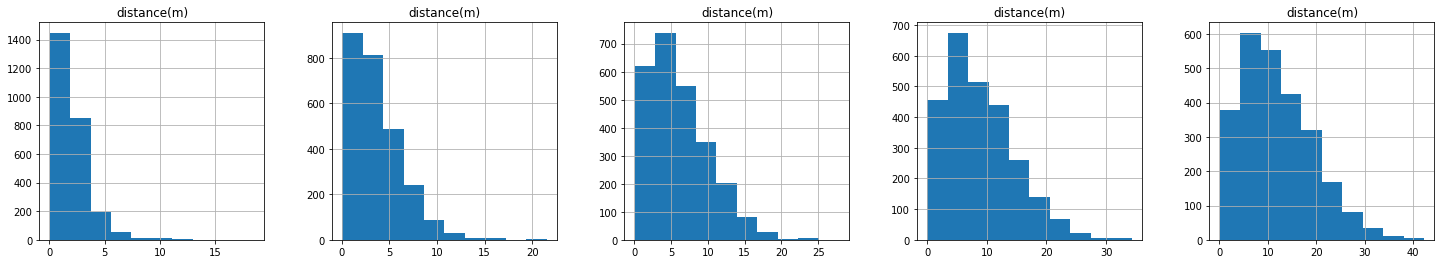

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [ ]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390739,2.164781,164.294300,41.390738,2.164781,164.311173,2.096470
std,0.000774,0.001164,98.635384,0.000773,0.001168,99.848942,1.662247
min,41.387373,2.158450,6.492594,41.387357,2.158374,33.558601,0.018056
25%,41.390238,2.163954,64.333754,41.390241,2.163942,56.929802,1.064978
50%,41.390384,2.164482,139.116629,41.390385,2.164491,138.082230,1.706684
75%,41.391153,2.165614,227.744144,41.391154,2.165618,226.209520,2.594549
max,41.393978,2.167407,330.242719,41.393990,2.167493,325.723594,18.498930


In [ ]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390742,2.164786,164.966075,41.390741,2.164790,163.786712,3.716232
std,0.000771,0.001173,96.496362,0.000770,0.001179,100.746739,2.675219
min,41.387286,2.158323,-1.370166,41.387281,2.158277,23.673287,0.042323
25%,41.390243,2.163877,68.396054,41.390247,2.163844,58.907796,1.674716
50%,41.390372,2.164514,140.935483,41.390368,2.164511,138.127025,3.089552
75%,41.391140,2.165665,227.144330,41.391147,2.165674,226.209520,5.167725
max,41.394021,2.167434,337.444558,41.394006,2.167493,325.723594,21.504474


In [ ]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390745,2.164790,166.055835,41.390746,2.164798,163.626592,6.118971
std,0.000769,0.001182,94.257216,0.000766,0.001191,101.859506,4.088891
min,41.387196,2.158182,2.651422,41.387195,2.158180,5.714497,0.062044
25%,41.390250,2.163827,72.254887,41.390257,2.163762,58.287742,2.922113
50%,41.390366,2.164538,143.270337,41.390352,2.164545,138.222234,5.306759
75%,41.391143,2.165685,227.316353,41.391152,2.165733,226.209520,8.555109
max,41.394061,2.167450,335.494858,41.394021,2.167493,329.427144,27.843262


In [ ]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390747,2.164792,167.201038,41.390751,2.164803,163.617546,8.941271
std,0.000767,0.001190,91.981739,0.000763,0.001203,102.413872,5.704205
min,41.387123,2.158086,9.100593,41.387111,2.158087,2.702005,0.023454
25%,41.390260,2.163783,78.204877,41.390277,2.163790,57.770335,4.442213
50%,41.390365,2.164560,145.665380,41.390339,2.164598,140.877186,8.048568
75%,41.391151,2.165706,228.275899,41.391141,2.165800,226.209520,12.416057
max,41.394133,2.167518,328.485273,41.394036,2.167506,343.864411,34.296146


In [ ]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),latitude,longitude,heading,distance(m)
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,41.390750,2.164794,168.696671,41.390755,2.164803,169.082277,11.946721
std,0.000765,0.001198,89.476920,0.000757,0.001216,103.386991,7.302124
min,41.387020,2.157980,17.644811,41.387022,2.157973,0.437611,0.097006
25%,41.390277,2.163790,87.017448,41.390288,2.163845,68.784840,6.077027
50%,41.390372,2.164584,147.647646,41.390365,2.164600,163.397659,10.778482
75%,41.391148,2.165716,229.478472,41.391129,2.165866,232.136389,16.642548
max,41.394220,2.167625,328.097354,41.394120,2.167527,359.748667,42.276455


#### 2.5.4.3. Métricas del modelo

In [ ]:
# Load fitted model
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(
    MODEL_FILE, custom_objects={'Attention': Attention})

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
            METRICS_FILE)

Total colision: 1000
TP: 40
FN: 960
Total no colision: 1000
FP: 28
TN: 972

Accuracy: 0.506
Precision: 0.5882352941176471
Recall: 0.04
F1 Score: 0.07490636704119849
Specificity: 0.972
